In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
from matplotlib.collections import LineCollection
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns
import cmocean

import numpy as np
import scipy
from scipy import signal
from scipy import stats as stats
from scipy.stats import binned_statistic
from scipy.io import loadmat
from scipy import ndimage
from scipy.ndimage import gaussian_filter

import mne
import pickle
import pandas as pd

import statsmodels
from statsmodels.formula.api import ols, mixedlm
import statsmodels.api as sm
from statsmodels.stats.anova import AnovaRM

from bycycle.filt import lowpass_filter
from bycycle.features import compute_features

from neurodsp import filt
from neurodsp.utils import create_times
from neurodsp.timefrequency import amp_by_time, freq_by_time, phase_by_time
from neurodsp.plts.time_series import plot_time_series, plot_instantaneous_measure
from neurodsp.burst import detect_bursts_dual_threshold
from neurodsp.plts import plot_time_series, plot_power_spectra, plot_bursts, plot_lagged_coherence
from neurodsp.spectral import compute_spectrum, trim_spectrum
from neurodsp.burst import detect_bursts_dual_threshold
from neurodsp.rhythm import compute_lagged_coherence
from neurodsp.plts import plot_time_series, plot_power_spectra, plot_bursts, plot_lagged_coherence
from neurodsp.utils import create_times
from neurodsp.rhythm import sliding_window_matching
from neurodsp.plts.rhythm import plot_swm_pattern
from neurodsp.plts.time_series import plot_time_series
from neurodsp.utils import create_times
from neurodsp.plts.time_series import plot_time_series
from neurodsp.plts.spectral import plot_spectral_hist
from neurodsp.plts.spectral import plot_scv, plot_scv_rs_lines, plot_scv_rs_matrix
from neurodsp import spectral

import dabest

from tensorpac import Pac
from tensorpac.signals import pac_signals_tort

In [266]:
plo = {}
plo['arena_early'] = 'lightsteelblue'
plo['arena_late'] = 'royalblue'
plo['hcage'] = 'darkkhaki'


plo['P1'] = '#113F67'
plo['P2'] = '#34699A'
plo['P3'] = '#408AB4'
plo['P4'] = '#65C6C4'


P_color_palette = {"P1" : plo['P1'],
                   "P2" : plo['P2'],
                   "P3" : plo['P3'],  
                   "P4" : plo['P4'] }


ticks_fontsize = 14
labels_fontsize = 16
fig_height = 3

fs = 400.


In [3]:

def hilbert_transform_get_component(tmp_lfp_notch, fs, low_amp_freq,high_amp_freq, component):
    
    '''
    Transform signal and get either phase or amplitude component
    component: 'phase' or 'amplitude'
    '''

    info = mne.create_info(ch_names=['lfp'], sfreq=fs, ch_types=['eeg'])
    raw = mne.io.RawArray([tmp_lfp_notch], info)
    
    if component == 'phase':

        raw_band = raw.copy()
        raw_band.filter(low_amp_freq,high_amp_freq, l_trans_bandwidth=2., h_trans_bandwidth=2., fir_design='firwin', verbose=False)
        raw_hilb = raw_band.copy()
        hilb_picks = mne.pick_types(raw_band.info, meg=False, eeg=True)
        raw_hilb.apply_hilbert(hilb_picks)
        raw_out = raw_hilb.copy()
        raw_out.apply_function(np.angle, hilb_picks)
        raw_out = raw_out.get_data()[0].real
        
    if component == 'amplitude':


        raw_band = raw.copy()
        raw_band.filter(low_amp_freq,high_amp_freq, l_trans_bandwidth=2., h_trans_bandwidth=2., fir_design='firwin', verbose=False)
        raw_hilb = raw_band.copy()
        hilb_picks = mne.pick_types(raw_band.info, meg=False, eeg=True)
        raw_hilb.apply_hilbert(hilb_picks)
        raw_out = raw_hilb.copy()
        raw_out.apply_function(np.abs, hilb_picks)
        raw_out = raw_out.get_data()[0].real

    return raw_out





def calculate_KB(bs):

    'PAD is the phase amp distribution'
    pad = bs[0]
    pad_2 = np.hstack((pad , pad))

    num_bins = pad_2.size
    n_pevents = float(np.sum(pad_2))
    ppp = -1 * np.sum((pad_2/n_pevents) * np.log((pad_2/n_pevents)))
    K_L = (np.log(num_bins) - ppp) / np.log(num_bins)

    return K_L



def smooth_psd(p, sz=40, sigma=10):
    '''
    sz :  length of gaussFilter vector
    sigma = 10
    '''
    x = np.linspace(-sz / 2, sz / 2, sz);
    gaussFilter = np.exp(-x** 2 / (2 * sigma**2));
    gaussFilter = gaussFilter / sum (gaussFilter); # normalize
    pp = np.convolve(p, gaussFilter, 'same');
    return pp


def CohenEffectSize(group1, group2):
    """Compute Cohen's d."""
    if type(group1)==list: group1=np.array(group1)
    if type(group2)==list: group2=np.array(group2)
    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    d = diff / np.sqrt(pooled_var)
    return d




def pearsonr_ci(x,y,alpha=0.05):
    ''' calculate Pearson correlation along with the confidence interval using scipy and numpy
    Parameters
    ----------
    x, y : iterable object such as a list or np.array
      Input for correlation calculation
    alpha : float
      Significance level. 0.05 by default
    Returns
    -------
    r : float
      Pearson's correlation coefficient
    pval : float
      The corresponding p value
    lo, hi : float
      The lower and upper bound of confidence intervals
    '''

    r, p = stats.pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(x.size-3)
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return r, p, lo, hi

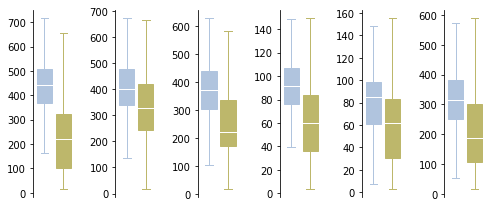

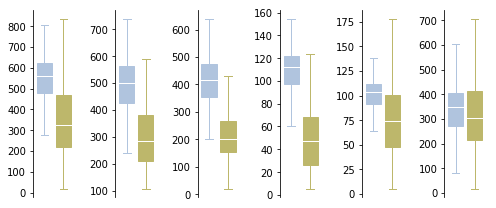

In [5]:
for session in range(1,3):

    fig,ax = plt.subplots(ncols=6, nrows=1, figsize=(7,3) )

    for rat in range(1,7):
        
        plt.sca(ax[rat-1])
        
        counter = 0
        for session_type in ['Arena','HCage']:
            data = loadmat('data/Rat_'+str(rat)+'_Type_'+session_type+'_Session_'+str(session)+'.mat')
            bxp = plt.boxplot(data['mov_data'][0], positions=[counter], sym='',widths=.4, patch_artist=True)        
            color = plo['hcage']
            if session_type == 'Arena': color = plo['arena_early']
            for item in ['boxes','whiskers','fliers','caps']: plt.setp(bxp[item],color=color)
            plt.setp(bxp['medians'],color='white')

            counter +=.5
        plt.xlim(-.3,.8)
        plt.xticks([])

    sns.despine(bottom=True)
    plt.tight_layout()

In [253]:
session = 1
session_type = 'Arena'

times_early_late = []
for rat in range(1,7):
    
    ## Arena (Early and Late)    
    data = loadmat('data/Rat_'+str(rat)+'_Type_'+session_type+'_Session_'+str(session)+'.mat')
    rat_mov = data['mov_data'][0]

    split = int(rat_mov.size/4)

#     early_times = [data['T_data'][0,0], data['T_data'][-1,split] ]
#     late_times  = [data['T_data'][0,split*2], data['T_data'][-1,split*3]  ]
    
    P1_times    = [data['T_data'][0,0], data['T_data'][-1,split]  ]
    P2_times    = [data['T_data'][0,split], data['T_data'][-1,split*2]  ]
    P3_times    = [data['T_data'][0,split*2], data['T_data'][-1,split*3]  ]
    P4_times    = [data['T_data'][0,split*3], data['T_data'][-1,split*4-1]  ]
    
    all_times   = [data['T_data'][:,0][0], data['T_data'][:,-1][1]]

    times_early_late.append([P1_times,P2_times,P3_times,P4_times,all_times])

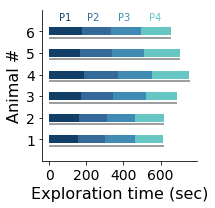

In [257]:
fig,ax = plt.subplots(ncols=1, nrows=1, figsize=(3,fig_height), facecolor='w' )

for rat in range(len(times_early_late)):
    plt.hlines(rat+1-0.3, times_early_late[rat][4][0],times_early_late[rat][4][1], color='grey' )
    
    plt.hlines(rat+1, times_early_late[rat][0][0],times_early_late[rat][0][1], color=plo['P1'], linewidth=8 )
    plt.hlines(rat+1, times_early_late[rat][1][0],times_early_late[rat][1][1], color=plo['P2'], linewidth=8 )
    plt.hlines(rat+1, times_early_late[rat][2][0],times_early_late[rat][2][1], color=plo['P3'], linewidth=8 )
    plt.hlines(rat+1, times_early_late[rat][3][0],times_early_late[rat][3][1], color=plo['P4'], linewidth=8 )
    
    
plt.text(0.15, 0.95,'P1', ha='center', va='center', transform=ax.transAxes, color=plo['P1'], fontsize=10)
plt.text(0.33, 0.95,'P2', ha='center', va='center', transform=ax.transAxes, color=plo['P2'], fontsize=10)
plt.text(0.53, 0.95,'P3', ha='center', va='center', transform=ax.transAxes, color=plo['P3'], fontsize=10)
plt.text(0.73, 0.95,'P4', ha='center', va='center', transform=ax.transAxes, color=plo['P4'], fontsize=10)
    
    
plt.xlabel('Exploration time (sec)', fontsize=labels_fontsize)
plt.ylabel('Animal #', fontsize=labels_fontsize)
plt.xticks( fontsize=ticks_fontsize)
plt.yticks( range(1,7), fontsize=ticks_fontsize)
plt.ylim(0,7)
sns.despine()

plt.tight_layout()
# plt.savefig('Figures/nav_duration.png',dpi=400)

In [298]:
times_session,times_chunk = [],[]

for rat in range(len(times_early_late)):
    print('rat:',rat+1, ' total (sec):', times_early_late[rat][2][1], ' chunk (sec):', times_early_late[rat][0][1]  )
    times_session.append(times_early_late[rat][2][1])
    times_chunk.append(times_early_late[rat][0][1])
    
times_session =np.array(times_session)
times_chunk =np.array(times_chunk)

print( '\n Average session time (sec):', np.mean(times_session), np.std(times_session) )
print( 'Average chunk time (sec):', np.mean(times_chunk), np.std(times_chunk) )

rat: 1  total (sec): 618.0025  chunk (sec): 157.9975
rat: 2  total (sec): 618.0025  chunk (sec): 163.9975
rat: 3  total (sec): 686.0025  chunk (sec): 175.9975
rat: 4  total (sec): 756.0025  chunk (sec): 189.9975
rat: 5  total (sec): 702.0025  chunk (sec): 165.9975
rat: 6  total (sec): 658.0025  chunk (sec): 179.9975

 Average session time (sec): 673.0025 48.60384072615387
Average chunk time (sec): 172.33083333333332 10.79608982713443


   Movement sensor early vs late exploration    


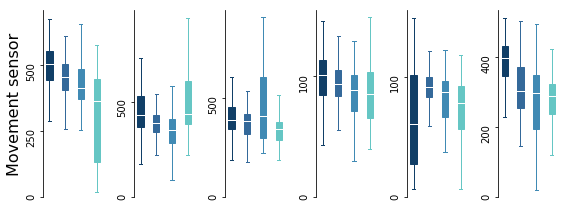

In [260]:
# all_movement_early = []
# all_movement_late = []

all_movement_P1 = []
all_movement_P2 = []
all_movement_P3 = []
all_movement_P4 = []

print('='*60)
print('   Movement sensor early vs late exploration    ')
print('='*60)

for session in range(1,2):

    fig,ax = plt.subplots(ncols=6, nrows=1, figsize=(8,3), facecolor='w' )


    for rat in range(1,7):
        plt.sca(ax[rat-1])

        
        ## Arena (Early and Late)
        session_type = 'Arena'
        data = loadmat('data/Rat_'+str(rat)+'_Type_'+session_type+'_Session_'+str(session)+'.mat')
        rat_mov = data['mov_data'][0]

        split = int(rat_mov.size/4)
        

#         early_mov = rat_mov[:split]
#         late_mov = rat_mov[split*2:split*3]
        P1_mov = rat_mov[:split]
        P2_mov = rat_mov[split*1:split*2]
        P3_mov = rat_mov[split*2:split*3]
        P4_mov = rat_mov[split*3:]
        
        

#         bxp = plt.boxplot(early_mov, positions=[0], sym='',widths=.4, patch_artist=True)
#         for item in ['boxes','whiskers','fliers','caps']: plt.setp(bxp[item],color=plo['arena_early'])
#         plt.setp(bxp['medians'],color='white')

#         bxp = plt.boxplot(late_mov, positions=[.5], sym='',widths=.4, patch_artist=True)
#         for item in ['boxes','whiskers','fliers','caps']: plt.setp(bxp[item],color=plo['arena_late'])
#         plt.setp(bxp['medians'],color='white')

        bxp = plt.boxplot(P1_mov, positions=[0], sym='',widths=.4, patch_artist=True)
        for item in ['boxes','whiskers','fliers','caps']: plt.setp(bxp[item],color=plo['P1'])
        plt.setp(bxp['medians'],color='white')
        
        bxp = plt.boxplot(P2_mov, positions=[1], sym='',widths=.4, patch_artist=True)
        for item in ['boxes','whiskers','fliers','caps']: plt.setp(bxp[item],color=plo['P2'])
        plt.setp(bxp['medians'],color='white')
        
        bxp = plt.boxplot(P3_mov, positions=[2], sym='',widths=.4, patch_artist=True)
        for item in ['boxes','whiskers','fliers','caps']: plt.setp(bxp[item],color=plo['P3'])
        plt.setp(bxp['medians'],color='white')
        
        bxp = plt.boxplot(P4_mov, positions=[3], sym='',widths=.4, patch_artist=True)
        for item in ['boxes','whiskers','fliers','caps']: plt.setp(bxp[item],color=plo['P4'])
        plt.setp(bxp['medians'],color='white')


        
#         all_movement_early.append( np.mean(early_mov) )
#         all_movement_late.append(  np.mean(late_mov))
        all_movement_P1.append(  np.mean(P1_mov)  )
        all_movement_P2.append(  np.mean(P2_mov)  )
        all_movement_P3.append(  np.mean(P3_mov)  )
        all_movement_P4.append(  np.mean(P4_mov)  )


#         print("Rat:", rat, stats.ttest_ind(early_mov,late_mov))
#         pval = stats.ttest_ind(early_mov,late_mov)[1]
#         sig_star = ''
#         if pval<=0.05: sig_star = '*' 
#         if pval<=0.01: sig_star = '**' 
#         if pval<=0.001: sig_star = '***' 
#         plt.text(0.6, 0.99,sig_star, ha='center', va='center', transform=ax[rat-1].transAxes, color='k', fontsize=14)


        if rat==1: plt.ylabel('Movement sensor', fontsize=labels_fontsize)
        plt.xticks([], fontsize=ticks_fontsize)
        plt.yticks( fontsize=ticks_fontsize-4, rotation=90)
        plt.xlim(-.4,3.4)
        plt.ylim(0)
        plt.locator_params(axis='y', nbins=3)

        
    sns.despine(bottom=True)
    plt.tight_layout()
    
    
# plt.savefig('Figures/mov_sensor.png',dpi=400)

# labels_fontsize
# ticks_fontsize
# fig_height

# all_movement_early = np.array(all_movement_early)
# all_movement_late  = np.array(all_movement_late)


all_movement_P1 = np.array(all_movement_P1)
all_movement_P2 = np.array(all_movement_P2)
all_movement_P3 = np.array(all_movement_P3)
all_movement_P4 = np.array(all_movement_P4)


In [23]:
# print( np.mean(all_movement_early),np.std(all_movement_early) )
# print( np.mean(all_movement_late),np.std(all_movement_late) )
# print( stats.ttest_rel( all_movement_late, all_movement_early) )

print( np.mean(all_movement_P1),np.std(all_movement_P1) )
print( np.mean(all_movement_P3),np.std(all_movement_P3) )
print( stats.ttest_rel( all_movement_P1, all_movement_P3) )

317.52149476490655 169.43199603564744
278.8792881354051 150.03571079638593
Ttest_relResult(statistic=1.3121108939108532, pvalue=0.24648905926685336)


# Power spectra

In [1002]:
session_type = 'Arena'
session = 1

all_psd = []
for rat in range(1,7):
    
    psd_mov = []
    data = loadmat('data/Rat_'+str(rat)+'_Type_'+session_type+'_Session_'+str(session)+'.mat')

    for ii in range(data['mov_data'][0].size):

        sig = data['LFP_data'][:,ii]

        # Calculate the power spectrum, using a median welch & extract a frequency range of interest
        freqs, powers = compute_spectrum(sig, fs, method='welch', avg_type='mean' )
        freqs, powers = trim_spectrum(freqs, powers, [1, 80])

        # Check where the peak power is
    #     peak_cf = freqs[np.argmax(powers)]
        peak_cf = freqs[ int(ndimage.measurements.center_of_mass(powers)[0]) ]

        psd_mov.append(  [freqs,powers]  )

    psd_mov = np.array(psd_mov)
    mm = np.mean(psd_mov[:,1,:],axis=0)
    all_psd.append([freqs,mm])
    
all_psd = np.array(all_psd)

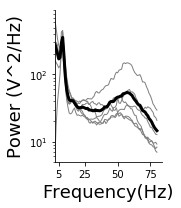

In [1013]:
# Plot the power spectra, and note the peak power
fig,ax = plt.subplots( figsize=(2.5,3), facecolor='w')
for rat in range(all_psd.shape[0]):
    plt.plot(all_psd[rat][0], all_psd[rat][1], 'grey', linewidth=1 )
    
plt.plot(np.mean(all_psd,axis=0)[0],np.mean(all_psd,axis=0)[1], 'k', linewidth=3 )
    
plt.yscale('log')
# plt.xscale('log')
plt.ylabel('Power (V^2/Hz)',fontsize=18)
plt.xlabel('Frequency(Hz)',fontsize=18)
plt.xlim(2)
plt.xticks( [5,25,50,75], [5,25,50,75] )
plt.ylim(5)
sns.despine()

plt.tight_layout()
plt.savefig('Figures/psd.png',dpi=400)

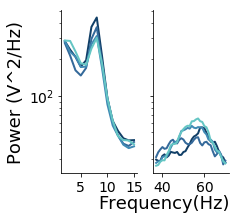

In [263]:
session_type = 'Arena'
session = 1


fig,ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(3,3), facecolor='w')
counter = 0

freq_bands = [ [2,15], [37,70] ]

for band_range in freq_bands:

#     all_psd_early,all_psd_late = [],[]
    P1_psd, P2_psd, P3_psd, P4_psd = [],[],[],[]
    for rat in range(1,7):


        data = loadmat('data/Rat_'+str(rat)+'_Type_'+session_type+'_Session_'+str(session)+'.mat')
        rat_mov = data['mov_data'][0]
        split = int(rat_mov.size/4)


        psd_mov = []
        for ii in range(split):
            sig = data['LFP_data'][:,ii]
            # Calculate the power spectrum, using a median welch & extract a frequency range of interest
            freqs, powers = compute_spectrum(sig, fs, method='welch', avg_type='mean')
            freqs, powers = trim_spectrum(freqs, powers, band_range)
            psd_mov.append( powers  )
        psd_mov = np.mean(np.array(psd_mov), axis=0 )
        #all_psd_early.append(psd_mov)
        P1_psd.append(psd_mov)

        psd_mov = []
        for ii in range(split,split*2):
            sig = data['LFP_data'][:,ii]
            # Calculate the power spectrum, using a median welch & extract a frequency range of interest
            freqs, powers = compute_spectrum(sig, fs, method='welch', avg_type='mean')
            freqs, powers = trim_spectrum(freqs, powers, band_range)
            psd_mov.append(  powers  )
        psd_mov = np.mean(np.array(psd_mov), axis=0 )
        #all_psd_late.append(psd_mov)
        P2_psd.append(psd_mov)
        
        
        psd_mov = []
        for ii in range(split*2,split*3):
            sig = data['LFP_data'][:,ii]
            # Calculate the power spectrum, using a median welch & extract a frequency range of interest
            freqs, powers = compute_spectrum(sig, fs, method='welch', avg_type='mean')
            freqs, powers = trim_spectrum(freqs, powers, band_range)
            psd_mov.append(  powers  )
        psd_mov = np.mean(np.array(psd_mov), axis=0 )
        #all_psd_late.append(psd_mov)
        P3_psd.append(psd_mov)

        psd_mov = []
        for ii in range(split*3,split*4):
            sig = data['LFP_data'][:,ii]
            # Calculate the power spectrum, using a median welch & extract a frequency range of interest
            freqs, powers = compute_spectrum(sig, fs, method='welch', avg_type='mean')
            freqs, powers = trim_spectrum(freqs, powers, band_range)
            psd_mov.append(  powers  )
        psd_mov = np.mean(np.array(psd_mov), axis=0 )
        #all_psd_late.append(psd_mov)
        P4_psd.append(psd_mov)
        
        
        
#     all_psd_early = np.array(all_psd_early)
#     all_psd_late = np.array(all_psd_late)
    P1_psd = np.array(P1_psd)
    P2_psd = np.array(P2_psd)
    P3_psd = np.array(P3_psd)
    P4_psd = np.array(P4_psd)


    ### Plot
    plt.sca(ax[counter])
    plt.plot(freqs, np.mean(P1_psd,axis=0), plo['P1'], linewidth=2 )
    plt.plot(freqs, np.mean(P2_psd,axis=0), plo['P2'], linewidth=2 )
    plt.plot(freqs, np.mean(P3_psd,axis=0), plo['P3'], linewidth=2 )
    plt.plot(freqs, np.mean(P4_psd,axis=0), plo['P4'], linewidth=2 )
#     plt.plot(freqs, np.mean(all_psd_late,axis=0), plo['arena_late'], linewidth=3 )
    plt.yscale('log')
    # plt.xscale('log')
    if counter == 0: plt.ylabel('Power (V^2/Hz)',fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14 )

    sns.despine()
    
    counter+=1
    
    
    
fig.text(0.6, -0.04, 'Frequency(Hz)', ha='center', fontsize=18)
# plt.tight_layout()

plt.savefig('Figures/theta_gamma_early_late_psd.png',dpi=400, bbox_inches='tight', pad_inches=0.1)

# Power spectra along exploration

In [962]:
def rebin(arr, new_shape):
    shape = (new_shape[0], arr.shape[0] // new_shape[0],
             new_shape[1], arr.shape[1] // new_shape[1])
    return arr.reshape(shape).mean(-1).mean(1)

In [963]:
session_type = 'Arena'
session = 1

all_psd = []
for rat in range(1,7):
    
    psd_mov = []
    data = loadmat('data/Rat_'+str(rat)+'_Type_'+session_type+'_Session_'+str(session)+'.mat')

    for ii in range(data['mov_data'][0].size):

        sig = data['LFP_data'][:,ii]

        # Calculate the power spectrum, using a median welch & extract a frequency range of interest
        freqs, powers = compute_spectrum(sig, fs, method='welch', avg_type='mean')
        freqs, powers = trim_spectrum(freqs, powers, [5.5, 10])

        psd_mov.append(powers)
    all_psd.append(psd_mov)
    
all_psd = np.array(all_psd)

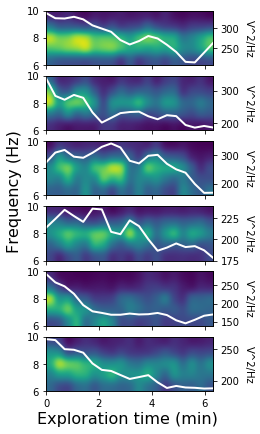

In [964]:
theta_decreases_all = []


fig,ax = plt.subplots(ncols=1, nrows=6, figsize=(3,7), facecolor='w', sharex=True )
n_samples = 190#280
for rat in range(6):
    
    ax1 = ax[rat]
    plt.sca(ax[rat])
    arr = np.array(all_psd[rat]).T[:20,:n_samples]
    n_arr = rebin(arr, ( arr.shape[0], int(arr.shape[1]/10) ) )
    plt.imshow( n_arr, aspect='auto', origin='low', interpolation='gaussian', 
               extent=[ 0, n_samples*2/60 , freqs[0], freqs[-1] ], cmap=None   )
    
    
    
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylabel('V^2/Hz', color='k', rotation=-90 )  # we already handled the x-label with ax1
    ax2.yaxis.set_label_coords(1.24,0.5)
    tmp_mean_theta_power = np.mean(  gaussian_filter(n_arr,.9), axis=0)
    tt = np.linspace(0,n_samples*2/60,tmp_mean_theta_power.size)
    ax2.plot( tt , tmp_mean_theta_power, color='w', linewidth=2)
    ax2.tick_params(axis='y', labelcolor='k')
    plt.xlim(0,n_samples*2/60)
    
    theta_decreases_all.append(tmp_mean_theta_power)

    
fig.text(0.5, 0.06, 'Exploration time (min)', ha='center', fontsize=labels_fontsize)
fig.text(-0.02, 0.62, 'Frequency (Hz)', ha='center', fontsize=labels_fontsize, rotation='vertical')


plt.savefig('Figures/theta_decay_spectrogram.png',dpi=400, bbox_inches='tight', pad_inches=0.1)

### Compute how linear is the theta power decay along exploration time by comparing it with a perfect linear function

In [966]:
theta_decrease_vs_linear = []
for ii in range(len(theta_decreases_all)):
    tmp = theta_decreases_all[ii]
    tmp -= tmp.min()
    tmp /= tmp.max()    
    linear_decrease = np.linspace(1,0,tmp.size)
    theta_decrease_vs_linear.append(linear_decrease-tmp)
theta_decrease_vs_linear = np.array(theta_decrease_vs_linear)

   Theta amplitude linear decay (time) correlation    
R: -0.9905725716402662 
p= 4.051965956173939e-16 
confid interval: -0.9964512682872624 -0.9750770163782687
Polynomial coefficients  
-0.1307 x + 0.8562


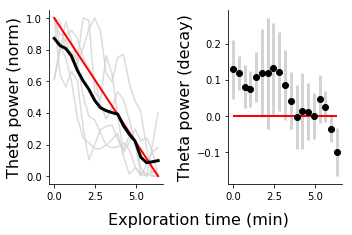

In [967]:
fig,ax = plt.subplots(1,2,figsize=(5,fig_height), facecolor='w'  )

########################################################################
plt.sca(ax[0])
for ii in range(len(theta_decreases_all)):
    tmp = theta_decreases_all[ii]
    xx = np.linspace(0,n_samples*2/60,tmp.size)
    plt.plot(xx, tmp, alpha=0.8, color='lightgrey')
    
linear_decrease = np.linspace(1,0,tmp.size)
plt.plot(xx, linear_decrease, 'r', linewidth=2)
plt.plot( xx, np.mean(np.array(theta_decreases_all),axis=0), 'k', linewidth=3 )
# plt.xlim(-.3,10)
plt.ylabel('Theta power (norm)', fontsize=labels_fontsize)

r,p,ci_min,ci_max = pearsonr_ci( xx, np.mean(np.array(theta_decreases_all),axis=0)  )
print('='*60)
print('   Theta amplitude linear decay (time) correlation    ')
print('='*60)
print( 'R:',r, '\np=',p, '\nconfid interval:', ci_min,ci_max  )
z = np.polyfit(xx, np.mean(np.array(theta_decreases_all),axis=0), 1)
p = np.poly1d(z)
print( 'Polynomial coefficients' , p)


########################################################################
plt.sca(ax[1])
mm = np.mean(theta_decrease_vs_linear,axis=0) 
ss = stats.sem(theta_decrease_vs_linear,axis=0) 
xx = np.linspace(0,n_samples*2/60,mm.size)
plt.errorbar(xx[::1], mm[::1], yerr=ss[::1], fmt='o', color='black',
             ecolor='lightgray', elinewidth=3, capsize=0);
plt.hlines(0,0, n_samples*2/60 , 'r', linewidth=2)
plt.ylabel('Theta power (decay)', fontsize=labels_fontsize)
fig.text(0.56, -0.06, 'Exploration time (min)', ha='center', fontsize=labels_fontsize)
# plt.xlim(-1)


########################################################################
# mm = np.mean(theta_decrease_vs_linear,axis=0) 
# ss = stats.sem(theta_decrease_vs_linear,axis=0) 
# xx = np.linspace(0,n_samples*2/60,mm.size)

# plt.sca(ax[2])
# for ii in range(4):
#     plt.errorbar( ii, np.mean(np.mean(theta_decrease_vs_linear[:,ii*7:ii*7+7],axis=1)),
#                       yerr=np.std(np.mean(theta_decrease_vs_linear[:,ii*7:ii*7+7],axis=1)),
#                       fmt='s', color='k',ecolor='lightgray',  linewidth=3)
    
# plt.hlines(0,-.2,3.2,'r')
# plt.xticks( range(4), ['q1','q2','q3','q4'] )#, fontsize=ticks_fontsize )
# # plt.yticks( fontsize=ticks_fontsize )
# # plt.xlabel('Exploration\n(quartile)', fontsize=labels_fontsize)
# plt.ylabel('Theta power (decay)', fontsize=labels_fontsize)
# sns.despine()



sns.despine()
plt.tight_layout()

plt.savefig('Figures/theta_decay_binned.png',dpi=400, bbox_inches='tight', pad_inches=0.1)


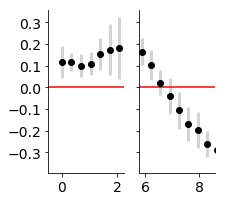

In [324]:
fig,ax = plt.subplots(1,2,figsize=(3,fig_height), sharey=True, facecolor='w' )

plt.sca(ax[0])
mm = np.mean(theta_decrease_vs_linear,axis=0) 
ss = stats.sem(theta_decrease_vs_linear,axis=0) 
xx = np.linspace(0,n_samples*2/60,mm.size)

plt.errorbar(xx, mm, yerr=ss, fmt='o', color='black',
             ecolor='lightgray', elinewidth=3, capsize=0);
plt.hlines(0,-.5,6.5, 'r')
plt.xlim(-.5,2.25)
# plt.ylim(-.35,.14)
sns.despine()
plt.xticks(fontsize=ticks_fontsize)
plt.yticks(fontsize=ticks_fontsize)



plt.sca(ax[1])
mm = np.mean(theta_decrease_vs_linear,axis=0) 
ss = stats.sem(theta_decrease_vs_linear,axis=0) 
xx = np.linspace(0,n_samples*2/60,mm.size)

plt.errorbar(xx, mm, yerr=ss, fmt='o', color='black',
             ecolor='lightgray', elinewidth=3, capsize=0);
plt.hlines(0,-.5,9.5, 'r')
plt.xlim(  172/60*2+0.06 ,172/60*3)

plt.xticks(fontsize=ticks_fontsize)
plt.yticks(fontsize=ticks_fontsize)

# plt.ylim(-.35,.14)
sns.despine()

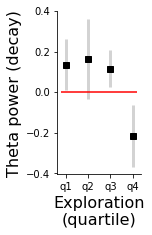

In [325]:
mm = np.mean(theta_decrease_vs_linear,axis=0) 
ss = stats.sem(theta_decrease_vs_linear,axis=0) 
xx = np.linspace(0,n_samples*2/60,mm.size)

fig,ax = plt.subplots(1,1,figsize=(1.5,fig_height), facecolor='w' )

plt.sca(ax)
for ii in range(4):
    plt.errorbar( ii, np.mean(np.mean(theta_decrease_vs_linear[:,ii*7:ii*7+7],axis=1)),
                      yerr=np.std(np.mean(theta_decrease_vs_linear[:,ii*7:ii*7+7],axis=1)),
                      fmt='s', color='k',ecolor='lightgray',  linewidth=3)
    
plt.hlines(0,-.2,3.2,'r')
plt.xticks( range(4), ['q1','q2','q3','q4'] )#, fontsize=ticks_fontsize )
# plt.yticks( fontsize=ticks_fontsize )
plt.xlabel('Exploration\n(quartile)', fontsize=labels_fontsize)
plt.ylabel('Theta power (decay)', fontsize=labels_fontsize)
sns.despine()

In [248]:
all_mean_theta_amp = []
for rat in range(6):

    arr = np.array(all_psd[rat]).T[:,:n_samples]

    n_arr = rebin(arr, ( arr.shape[0], int(arr.shape[1]/10) ) )

    n_arr_gaus = gaussian_filter(n_arr, .9 )

    mean_theta_amp = np.mean(n_arr_gaus,axis=0)
    mean_theta_amp -= mean_theta_amp.min()
    mean_theta_amp /= mean_theta_amp.max()
#     plt.plot(  mean_theta_amp )
    all_mean_theta_amp.append(mean_theta_amp)
    
all_mean_theta_amp = np.array(all_mean_theta_amp)

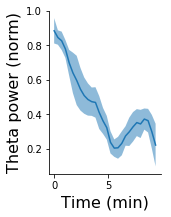

In [249]:
fig,ax = plt.subplots(1,1,figsize=(2,fig_height))
mm = np.mean(all_mean_theta_amp,axis=0)
ss = stats.sem(all_mean_theta_amp,axis=0)
tt = np.linspace(0,n_samples*2/60,tmp_mean_theta_power.size)

plt.fill_between(  tt, mm-ss,mm+ss, alpha=0.5 )
plt.plot(  tt, mm )
plt.xlabel('Time (min)', fontsize=labels_fontsize)
plt.ylabel('Theta power (norm)', fontsize=labels_fontsize)

sns.despine()

In [257]:
session_type = 'Arena'
session = 1

all_movs = []
for rat in range(1,7):
    data = loadmat('data/Rat_'+str(rat)+'_Type_'+session_type+'_Session_'+str(session)+'.mat')
    all_movs.append(data['mov_data'][0][:n_samples])

In [258]:
# all_movs[rat].shape
n_samples

280

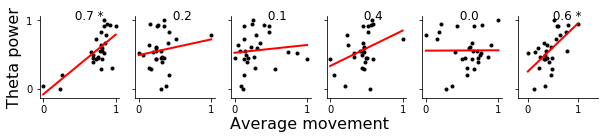

In [260]:
fig,ax = plt.subplots(1,6, figsize=(10,fig_height/2), sharey=True, facecolor='w' )

for rat in range(6):
    
    plt.sca(ax[rat])
    xx = all_movs[rat].reshape(28, 10).mean(axis=1)
    xx -= xx.min()
    xx /= xx.max()
    yy = all_mean_theta_amp[0]
    plt.plot(xx, yy,'.',color='k')
    r_corr,p_val =  stats.pearsonr(xx,yy)
    
    z = np.polyfit(xx, yy, 1)
    p = np.poly1d(z)
    
    xp = np.linspace(xx.min(), xx.max(), 10)
    sig_string = ' ' + str(np.around(r_corr,1))
    if p_val<0.05: sig_string+= ' *'
    else: sig_string+= '  '
    plt.plot(xp, p(xp), color='r', linewidth=2)
    
    plt.text(0.8,1,sig_string, ha='right', va='center', transform=ax[rat].transAxes, color='k', fontsize=12)
    #plt.text(.95,1-rat/9-0.35,sig_string, ha='right', va='center', transform=ax[rat].transAxes, color='C'+str(rat+1), fontsize=12)
    if rat==0: plt.ylabel('Theta power', fontsize=labels_fontsize)
    
fig.text(0.5, -0.16, 'Average movement', ha='center', fontsize=labels_fontsize)

plt.xticks([0,1])
plt.yticks([0,1])
plt.xlim(-.2,1.4)
sns.despine()



In [969]:
session_type = 'Arena'
session = 1

f_range = (4, 10)

power_amp = []
for rat in range(1,7):
    
    data = loadmat('data/Rat_'+str(rat)+'_Type_'+session_type+'_Session_'+str(session)+'.mat')
    
    for ii in range(data['LFP_data'].shape[1]):

        lfp = data['LFP_data'][:,ii]
        mov = data['mov_data'][0][ii]

        amp = amp_by_time(lfp, fs, f_range)
        power_amp.append(  [rat, ii, mov, np.nanmean(amp)]  )
        
power_amp = np.array(power_amp)
power_amp = pd.DataFrame(power_amp, columns=['rat','chunk','mov','amp'])

===== Movement signal correlation with theta power ===== 

  r | pval | low conf interval | high low conf interval 


 Rat: 1
(0.28225791508572373, 1.3945829005428566e-06, 0.17129790861171434, 0.38614711129017254)

 Rat: 2
(-0.13789419817624807, 0.016490540711646656, -0.24691605487099252, -0.02542519319806746)

 Rat: 3
(-0.07383865796792095, 0.17954319991035833, -0.18004539500864714, 0.03406982913993794)

 Rat: 4
(0.06967838771139385, 0.19089214520464637, -0.034809586209843396, 0.17265952643871343)

 Rat: 5
(-0.059351818911683306, 0.2959879565382536, -0.16927493360452817, 0.05202977091925102)

 Rat: 6
(0.02725041895236777, 0.6434055529342386, -0.08800654836839965, 0.1417873761059541)


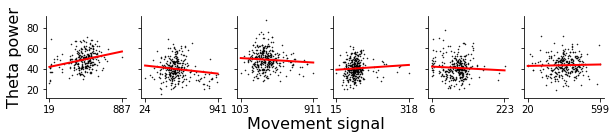

In [971]:
print('='*60)
print('===== Movement signal correlation with theta power ===== \n')
print( '  r | pval | low conf interval | high low conf interval \n'  )


fig,ax = plt.subplots(1,6, figsize=(10,fig_height/2), sharey=True, facecolor='w' )

for rat in power_amp['rat'].unique():
    print('\n Rat:', int(rat))
    
    plt.sca(ax[int(rat)-1])    
    tmp_mov = power_amp[power_amp['rat']==rat]['mov']
    tmp_amp = power_amp[power_amp['rat']==rat]['amp']    
    print( pearsonr_ci(tmp_mov,tmp_amp,alpha=0.05) )
    plt.plot(tmp_mov,tmp_amp,'.k', markersize=1)
    
    z = np.polyfit(tmp_mov, tmp_amp, 1)
    p = np.poly1d(z)    
    xp = np.linspace(tmp_mov.min(), tmp_mov.max(), 10)
    plt.plot(xp, p(xp), color='r', linewidth=2)
    
    xtimin,xtimax = int(tmp_mov.min()),int(tmp_mov.max())    
    plt.xticks([xtimin,xtimax],[xtimin,xtimax])
    
    if rat==1: plt.ylabel('Theta power', fontsize=labels_fontsize)


sns.despine()

fig.text(0.5, -0.16, 'Movement signal', ha='center', fontsize=labels_fontsize)

plt.savefig('Figures/theta_movement_corrs.png',dpi=400, bbox_inches='tight', pad_inches=0.1)

# Theta-gamma coupling
### Is not affected by exploration period

In [25]:
fs = 400.
Fs = 400.

In [ ]:
session = 1
session_type = 'Arena'

theta_gamma_coupling = []
for rat in range(1,7):

    data = loadmat('data/Rat_'+str(rat)+'_Type_'+session_type+'_Session_'+str(session)+'.mat')

    for ii in range(data['LFP_data'].shape[1]):

        lfp = data['LFP_data'][:,ii]
        mov = data['mov_data'][0][ii]

        low_amp_freq,high_amp_freq = 4,10
        theta_phase = hilbert_transform_get_component(lfp, fs, low_amp_freq,high_amp_freq, 'phase')

        low_amp_freq,high_amp_freq = 40,80
        gamma_amp = hilbert_transform_get_component(lfp, fs, low_amp_freq,high_amp_freq, 'amplitude')

        bs = binned_statistic(theta_phase,gamma_amp, bins=20, statistic='mean')
        theta_gamma_coupling.append( [rat, ii, mov, calculate_KB(bs)])

theta_gamma_coupling = np.array(theta_gamma_coupling)

In [27]:
theta_gamma_coupling = pd.DataFrame(theta_gamma_coupling, columns=['rat','chunk','mov','kb'])

Rat: 1 Ttest_indResult(statistic=-1.2003189368148297, pvalue=0.23205717765038847)
Rat: 2 Ttest_indResult(statistic=-1.6595007423621482, pvalue=0.0991182556412118)
Rat: 3 Ttest_indResult(statistic=-1.3043358155589038, pvalue=0.19394666552639828)
Rat: 4 Ttest_indResult(statistic=-1.7545987603838464, pvalue=0.08107813607892701)
Rat: 5 Ttest_indResult(statistic=0.6939260803772224, pvalue=0.48877397819023594)
Rat: 6 Ttest_indResult(statistic=-1.5086059723586964, pvalue=0.13360574028754468)


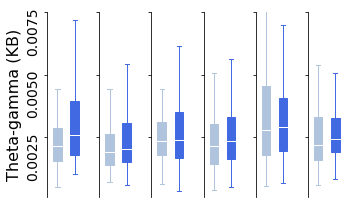

In [28]:
tgc_mean_early = []
tgc_mean_late = []


fig,ax = plt.subplots(ncols=6, nrows=1, figsize=(5,3), facecolor='w', sharey=True )
for rat in range(1,7):
    tmp = theta_gamma_coupling.query(' rat==' + str(rat))
    split = tmp['chunk'].values.max()/4
    
    plt.sca(ax[rat-1])
    
    early_coupling = tmp.query('chunk<'+str(split) ).kb.values
#     early_duration = tmp.query('chunk<'+str(split) ).duration.values/fs
#     early_mov = tmp.query('chunk<'+str(split) ).mov.values


    late_coupling = tmp.query(  'chunk>'+str(split*2)+  '& chunk<'+str(split*3) ).kb.values
#     late_duration = tmp.query(  'chunk>'+str(split*2)+  '& chunk<'+str(split*3) ).duration.values/fs
#     late_mov = tmp.query(  'chunk>'+str(split*2)+  '& chunk<'+str(split*3)).mov.values


    bxp = plt.boxplot(early_coupling, positions=[0], sym='',widths=.5, patch_artist=True)
    for item in ['boxes','whiskers','fliers','caps']: plt.setp(bxp[item],color=plo['arena_early'])
    plt.setp(bxp['medians'],color='white')
    
    bxp = plt.boxplot(late_coupling, positions=[1], sym='',widths=.5, patch_artist=True)
    for item in ['boxes','whiskers','fliers','caps']: plt.setp(bxp[item],color=plo['arena_late'])
    plt.setp(bxp['medians'],color='white')
    
    
    print("Rat:", rat, stats.ttest_ind(early_coupling,late_coupling))
    pval = stats.ttest_ind(early_coupling,late_coupling)[1]
    sig_star = ''
    if pval<=0.05: sig_star = '*' 
    if pval<=0.01: sig_star = '**' 
    if pval<=0.001: sig_star = '***' 
    plt.text(0.6, 0.99,sig_star, ha='center', va='center', transform=ax[rat-1].transAxes, color='k', fontsize=14)

    
    tgc_mean_early.append( np.median(early_coupling) )
    tgc_mean_late.append( np.median(late_coupling) )

    
    if rat==1: plt.ylabel('Theta-gamma (KB)', fontsize=labels_fontsize)
    plt.xticks([])
    plt.yticks(rotation=90, fontsize=ticks_fontsize)
    plt.xlim(-.6,1.4)
    plt.ylim(0.0001)
    plt.locator_params(axis='y', nbins=3)


sns.despine(bottom=True)
plt.tight_layout()

In [34]:
theta_gamma_averaged = []

for rat in range(1,7):
    
    tmp = theta_gamma_coupling.query(' rat==' + str(rat))
    split = tmp['chunk'].values.max()/4

    theta_gamma_averaged.append( [  np.mean(tmp.query('chunk<'+str(split) ).kb.values) ,
                                    np.mean(tmp.query(  'chunk>'+str(split)+' & chunk<'+str(split*2) ).kb.values),
                                    np.mean(tmp.query(  'chunk>'+str(split*2)+' & chunk<'+str(split*3) ).kb.values),
                                    np.mean(tmp.query(  'chunk>'+str(split*3) ).kb.values)   ] )

theta_gamma_averaged = np.array(theta_gamma_averaged)


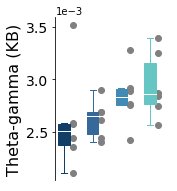

In [264]:
fig,ax = plt.subplots( figsize=(2,3), facecolor='w')

# plt.plot([.2,.8] ,theta_gamma_averaged.T, 'k', color='grey' );
# plt.plot([.2,.8] ,theta_gamma_averaged.T[0:2], 'k', color='grey' );
# plt.plot([1.2,1.8] ,theta_gamma_averaged.T[1:3], 'k', color='grey' );
# plt.plot([2.2,2.8] ,theta_gamma_averaged.T[2:4], 'k', color='grey' );

plt.plot( np.arange(4)+0.3, theta_gamma_averaged.T, 'o', color='grey' );


bxp = plt.boxplot(theta_gamma_averaged[:,0], positions=[0], sym='',widths=.4, patch_artist=True)
for item in ['boxes','whiskers','fliers','caps']: plt.setp(bxp[item],color=plo['P1'])
plt.setp(bxp['medians'],color='white')

bxp = plt.boxplot(theta_gamma_averaged[:,1], positions=[1], sym='',widths=.4, patch_artist=True)
for item in ['boxes','whiskers','fliers','caps']: plt.setp(bxp[item],color=plo['P2'])
plt.setp(bxp['medians'],color='white')

bxp = plt.boxplot(theta_gamma_averaged[:,2], positions=[2], sym='',widths=.4, patch_artist=True)
for item in ['boxes','whiskers','fliers','caps']: plt.setp(bxp[item],color=plo['P3'])
plt.setp(bxp['medians'],color='white')

bxp = plt.boxplot(theta_gamma_averaged[:,3], positions=[3], sym='',widths=.4, patch_artist=True)
for item in ['boxes','whiskers','fliers','caps']: plt.setp(bxp[item],color=plo['P4'])
plt.setp(bxp['medians'],color='white')


st, pv = stats.ttest_rel(theta_gamma_averaged[:,0],theta_gamma_averaged[:,1])
if pv<0.05:
    plt.text(0.5, 0.98,"*", fontsize=18, ha='center', va='center', transform=ax.transAxes, color='k')


# plt.ylim(0.103,0.117)
plt.xticks([])
plt.xlim(-.3,3.6)
plt.ylabel('Theta-gamma (KB)', fontsize=labels_fontsize)
plt.yticks(fontsize=ticks_fontsize)
plt.locator_params(axis='y', nbins=2)
plt.ticklabel_format(axis='y',style='sci',scilimits=(1,2))

sns.despine(bottom=True)


# plt.savefig('Figures/theta_gamma_KB.png',dpi=400, bbox_inches='tight', pad_inches=0.1)

In [55]:
print('='*60)
print( 'Theta-Gamma coupling early vs late' )
print( stats.ttest_rel(theta_gamma_averaged[:,0],theta_gamma_averaged[:,1]) )
print( stats.ttest_rel(theta_gamma_averaged[:,0],theta_gamma_averaged[:,2]) )
print( stats.ttest_rel(theta_gamma_averaged[:,0],theta_gamma_averaged[:,3]) )
print( 'CohenEffectSize', CohenEffectSize(theta_gamma_averaged[:,0],theta_gamma_averaged[:,1]))
print( 'Early mean/std', np.mean(theta_gamma_averaged[:,0]), np.std(theta_gamma_averaged[:,0])  )
print( 'Late mean/std', np.mean(theta_gamma_averaged[:,1]), np.std(theta_gamma_averaged[:,1])  )

Theta-Gamma coupling early vs late
Ttest_relResult(statistic=-0.1441741905012751, pvalue=0.8909938138302655)
Ttest_relResult(statistic=-2.4698355955914097, pvalue=0.05654162835148796)
Ttest_relResult(statistic=-2.711440289465274, pvalue=0.04220358541215489)
CohenEffectSize -0.07196645514746243
Early mean/std 0.0025951023697026823 0.00044399914847605295
Late mean/std 0.002619271563626867 0.00016864574429618985


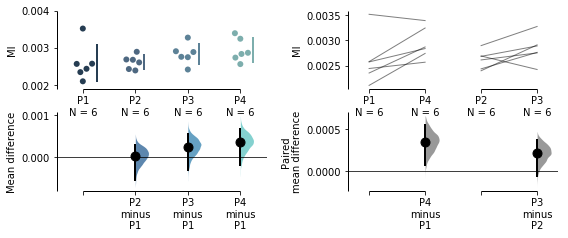

In [267]:

# ### Format data for dabest
# cond = np.array((['P1','P2','P3','P4']*6)).reshape(6,4).T
# subs = np.tile(np.arange(6),4).reshape(4,6)
# theta_gamma_means_formated = np.array([np.ravel(subs),np.ravel(cond),np.ravel(theta_gamma_averaged.T)]).T
# theta_gamma_means_pd = pd.DataFrame( data=theta_gamma_means_formated, columns=['sub','exploration','MI'] )
# theta_gamma_means_pd['MI'] = theta_gamma_means_pd['MI'].astype(float)


# ### Compute dabest
# theta_gamma_means_dabest = dabest.load(data=theta_gamma_means_pd, x='exploration', y='MI',
#                                        idx=("P1", "P2", "P3", "P4"))

# theta_gamma_means_dabest_paired = dabest.load(data=theta_gamma_means_pd, x='exploration', y='MI',
#                                       idx=(("P1", "P4"),
#                                            ("P2", "P3")), paired=True, id_col="sub")



#### plot dabest
fig,ax = plt.subplots(ncols=2,nrows=1, figsize=(8,2), facecolor='w')
theta_gamma_means_dabest.mean_diff.plot( ax=ax[0], swarm_ylim=(0.0019, 0.004), custom_palette=P_color_palette );
theta_gamma_means_dabest_paired.mean_diff.plot( ax=ax[1] );
plt.tight_layout()

In [ ]:
session = 1
session_type = 'Arena'

amp_phase_distr = []

for rat in range(1,7):
    
    tmp = []

    data = loadmat('data/Rat_'+str(rat)+'_Type_'+session_type+'_Session_'+str(session)+'.mat')

    for ii in range(data['LFP_data'].shape[1]):

        lfp = data['LFP_data'][:,ii]
        mov = data['mov_data'][0][ii]

        low_amp_freq,high_amp_freq = 4,10
        theta_phase = hilbert_transform_get_component(lfp, fs, low_amp_freq,high_amp_freq, 'phase')

        low_amp_freq,high_amp_freq = 40,80
        gamma_amp = hilbert_transform_get_component(lfp, fs, low_amp_freq,high_amp_freq, 'amplitude')

        bs = binned_statistic(theta_phase,gamma_amp, bins=36, statistic='mean')

        tmp.append([bs[1][:-1], bs[0]])
        
    amp_phase_distr.append(tmp)

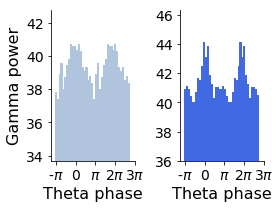

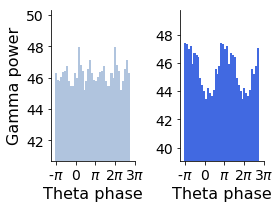

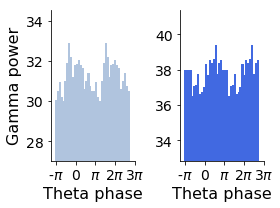

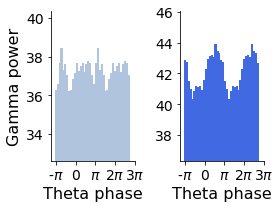

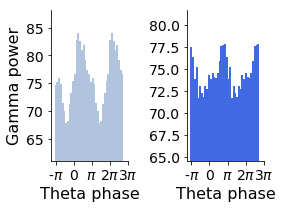

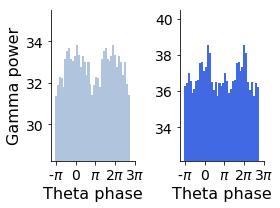

In [974]:
for rat in range(6):
    
    split = int(len(amp_phase_distr[rat])/4)

    fig,ax = plt.subplots(1,2,figsize=(4,fig_height), sharey=False, facecolor='w')


    tmp_phase,tmp_amp = [],[]
    for chunk in range(split,):
        tmp_phase.append(amp_phase_distr[rat][chunk][0])
        tmp_amp.append(amp_phase_distr[rat][chunk][1])
    bs = binned_statistic(np.concatenate(tmp_phase),np.concatenate(tmp_amp), bins=20, statistic='mean')

    tmp_phase = bs[1][:-1]
    tmp_amp = bs[0]
    double_phase = np.hstack((tmp_phase,tmp_phase+tmp_phase.max()+abs(tmp_phase.min()) ))
    double_amp = np.hstack((tmp_amp,tmp_amp))

    plt.sca(ax[0])
    plt.bar(double_phase,double_amp, width=.35, color=plo['arena_early'])
    plt.ylim( double_amp.min()*.9 )
    plt.xlabel('Theta phase', fontsize=labels_fontsize)
    plt.ylabel('Gamma power', fontsize=labels_fontsize)
    plt.xticks([-np.pi,0,np.pi,2*np.pi,3*np.pi],[ '-$\pi$',0,'$\pi$','2$\pi$','3$\pi$'], fontsize=ticks_fontsize);
    plt.yticks(fontsize=ticks_fontsize)
    sns.despine()



    tmp_phase,tmp_amp = [],[]
    for chunk in range(split*2,split*3):
        tmp_phase.append(amp_phase_distr[rat][chunk][0])
        tmp_amp.append(amp_phase_distr[rat][chunk][1])
    bs = binned_statistic(np.concatenate(tmp_phase),np.concatenate(tmp_amp), bins=20, statistic='mean')

    tmp_phase = bs[1][:-1]
    tmp_amp = bs[0]
    double_phase = np.hstack((tmp_phase,tmp_phase+tmp_phase.max()+abs(tmp_phase.min()) ))
    double_amp = np.hstack((tmp_amp,tmp_amp))

    
    plt.sca(ax[1])
    plt.bar(double_phase,double_amp, width=.35, color=plo['arena_late'])
    plt.ylim( double_amp.min()*.9 )
    plt.xlabel('Theta phase', fontsize=labels_fontsize)
#     plt.ylabel('Gamma power', fontsize=labels_fontsize)
    plt.xticks([-np.pi,0,np.pi,2*np.pi,3*np.pi],[ '-$\pi$',0,'$\pi$','2$\pi$','3$\pi$'], fontsize=ticks_fontsize);
    plt.yticks(fontsize=ticks_fontsize)

    sns.despine()
    
    plt.tight_layout()
    
    
    plt.savefig("Figures/pacs_dists/rat_"+str(rat+1)+"_pac.png",dpi=400, bbox_inches='tight', pad_inches=0.1)

    

# Power amplitude

In [67]:
session_type = 'Arena'
session = 1

f_range = (5, 10)

power_amp = []
for rat in range(1,7):
    
    data = loadmat('data/Rat_'+str(rat)+'_Type_'+session_type+'_Session_'+str(session)+'.mat')

    for ii in range(data['LFP_data'].shape[1]):

        lfp = data['LFP_data'][:,ii]
        mov = data['mov_data'][0][ii]

        amp = amp_by_time(lfp, fs, f_range)
        power_amp.append(  [rat, ii, mov, np.nanmean(amp)]  )
        
power_amp = np.array(power_amp)
power_amp = pd.DataFrame(power_amp, columns=['rat','chunk','mov','amp'])

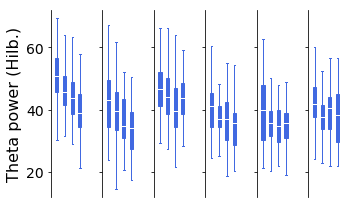

In [92]:
# theta_hilb_early = []
# theta_hilb_late = []

theta_hilb_P1 = []
theta_hilb_P2 = []
theta_hilb_P3 = []
theta_hilb_P4 = []

fig,ax = plt.subplots(ncols=6, nrows=1, figsize=(5,3), facecolor='w', sharey=True )

for rat in range(1,7):
    
    tmp = power_amp.query(' rat==' + str(rat))
    split = tmp['chunk'].values.max()/4
    
    plt.sca(ax[rat-1])
    
#     early_amp = tmp.query('chunk<'+str(split) ).amp.values
#     late_amp = tmp.query(  'chunk>'+str(split*2)+  '& chunk<'+str(split*3) ).amp.values
    
    
    P1_amp = tmp.query('chunk<'+str(split) ).amp.values
    P2_amp = tmp.query(  'chunk>'+str(split)+' & chunk<'+str(split*2) ).amp.values
    P3_amp = tmp.query(  'chunk>'+str(split*2)+' & chunk<'+str(split*3) ).amp.values
    P4_amp = tmp.query(  'chunk>'+str(split*3) ).amp.values
    
    
    
#     pval = stats.ttest_ind(early_amp,late_amp)[1]
#     sig_star = ''
#     if pval<=0.05: sig_star = '*' 
#     if pval<=0.01: sig_star = '**' 
#     if pval<=0.001: sig_star = '***' 
#     plt.text(0.6, 0.9,sig_star, ha='center', va='center', transform=ax[rat-1].transAxes, color='k', fontsize=14)
    
    
    
    
#     bxp = plt.boxplot(early_amp, positions=[0], sym='',widths=.4, patch_artist=True)
#     for item in ['boxes','whiskers','fliers','caps']: plt.setp(bxp[item],color=plo['arena_early'])
#     plt.setp(bxp['medians'],color='white')
    
    
#     bxp = plt.boxplot(late_amp, positions=[1], sym='',widths=.4, patch_artist=True)
#     for item in ['boxes','whiskers','fliers','caps']: plt.setp(bxp[item],color=plo['arena_late'])
#     plt.setp(bxp['medians'],color='white')


    bxp = plt.boxplot(P1_amp, positions=[0], sym='',widths=.4, patch_artist=True)
    for item in ['boxes','whiskers','fliers','caps']: plt.setp(bxp[item],color=plo['arena_late'])
    plt.setp(bxp['medians'],color='white')

    bxp = plt.boxplot(P2_amp, positions=[1], sym='',widths=.4, patch_artist=True)
    for item in ['boxes','whiskers','fliers','caps']: plt.setp(bxp[item],color=plo['arena_late'])
    plt.setp(bxp['medians'],color='white')
    
    bxp = plt.boxplot(P3_amp, positions=[2], sym='',widths=.4, patch_artist=True)
    for item in ['boxes','whiskers','fliers','caps']: plt.setp(bxp[item],color=plo['arena_late'])
    plt.setp(bxp['medians'],color='white')

    bxp = plt.boxplot(P4_amp, positions=[3], sym='',widths=.4, patch_artist=True)
    for item in ['boxes','whiskers','fliers','caps']: plt.setp(bxp[item],color=plo['arena_late'])
    plt.setp(bxp['medians'],color='white')



    if rat==1: plt.ylabel('Theta power (Hilb.)', fontsize=labels_fontsize)
    plt.xticks([])
    plt.yticks(fontsize=ticks_fontsize)
    plt.xlim(-.8,3.6)
    plt.locator_params(axis='y', nbins=4)
    
#     theta_hilb_early.append( np.mean(early_amp) )
#     theta_hilb_late.append( np.mean(late_amp) )

    theta_hilb_P1.append(np.mean(P1_amp))
    theta_hilb_P2.append(np.mean(P2_amp))
    theta_hilb_P3.append(np.mean(P3_amp))
    theta_hilb_P4.append(np.mean(P4_amp))


sns.despine(bottom=True)
plt.tight_layout()


# plt.savefig("Figures/theta_power_individuals.png",dpi=400, bbox_inches='tight', pad_inches=0.1)

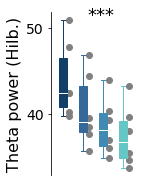

In [268]:
fig,ax = plt.subplots( figsize=(1.5,3), facecolor='w')

plt.plot( np.arange(4)+0.3, [theta_hilb_P1,theta_hilb_P2,theta_hilb_P3,theta_hilb_P4], 'o', color='grey')

bxp = plt.boxplot(theta_hilb_P1, positions=[0], sym='',widths=.4, patch_artist=True)
for item in ['boxes','whiskers','fliers','caps']: plt.setp(bxp[item],color=plo['P1'])
plt.setp(bxp['medians'],color='white')

bxp = plt.boxplot(theta_hilb_P2, positions=[1], sym='',widths=.4, patch_artist=True)
for item in ['boxes','whiskers','fliers','caps']: plt.setp(bxp[item],color=plo['P2'])
plt.setp(bxp['medians'],color='white')

bxp = plt.boxplot(theta_hilb_P3, positions=[2], sym='',widths=.4, patch_artist=True)
for item in ['boxes','whiskers','fliers','caps']: plt.setp(bxp[item],color=plo['P3'])
plt.setp(bxp['medians'],color='white')

bxp = plt.boxplot(theta_hilb_P4, positions=[3], sym='',widths=.4, patch_artist=True)
for item in ['boxes','whiskers','fliers','caps']: plt.setp(bxp[item],color=plo['P4'])
plt.setp(bxp['medians'],color='white')


plt.text(0.6, 0.98,"***", fontsize=18, ha='center', va='center', transform=ax.transAxes, color='k')

# plt.ylim(0.103,0.117)
plt.xticks([])
plt.xlim(-.6,3.6)
plt.ylabel('Theta power (Hilb.)', fontsize=labels_fontsize)
plt.yticks(fontsize=ticks_fontsize)
plt.locator_params(axis='y', nbins=2)

sns.despine(bottom=True)

# plt.savefig("Figures/theta_power_population.png",dpi=400, bbox_inches='tight', pad_inches=0.1)

In [472]:
print( 'Hilbert theta amplitude: population level, two-sided t-test' )
print( stats.ttest_rel(theta_hilb_early,theta_hilb_late) )
print( 'CohenEffectSize', CohenEffectSize(theta_hilb_early,theta_hilb_late))
print( 'Early mean/std', np.mean(theta_hilb_early), np.std(theta_hilb_early)  )
print( 'Late mean/std', np.mean(theta_hilb_late), np.std(theta_hilb_late)  )

Hilbert theta amplitude: population level, two-sided t-test
Ttest_relResult(statistic=7.026292083312814, pvalue=0.0009010623482241446)
CohenEffectSize 1.4872824623674432
Early mean/std 43.97718534658552 4.058833182807999
Late mean/std 38.650126256308624 3.03044486556268


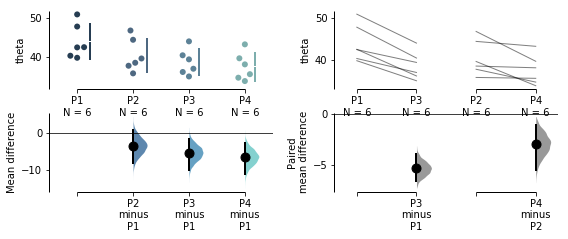

In [272]:

# ### Format data for dabest
# theta_hilb_means = np.array([theta_hilb_P1,theta_hilb_P2,theta_hilb_P3,theta_hilb_P4])
# cond = np.array((['P1','P2','P3','P4']*6)).reshape(6,4).T
# subs = np.tile(np.arange(6),4).reshape(4,6)
# theta_hilb_means_formated = np.array([np.ravel(subs),np.ravel(cond),np.ravel(theta_hilb_means)]).T
# theta_hilb_means_pd = pd.DataFrame( data=theta_hilb_means_formated, columns=['sub','exploration','theta'] )
# theta_hilb_means_pd['theta'] = theta_hilb_means_pd['theta'].astype(float)


# ### Compute dabest
# theta_hilb_means_dabest = dabest.load(data=theta_hilb_means_pd, x='exploration', y='theta',
#                                        idx=("P1", "P2", "P3", "P4"))

# theta_hilb_means_dabest_paired = dabest.load(data=theta_hilb_means_pd, x='exploration', y='theta',
#                                       idx=(("P1", "P3"),
#                                            ("P2", "P4")), paired=True, id_col="sub")


#### plot dabest
fig,ax = plt.subplots(ncols=2,nrows=1, figsize=(8,2), facecolor='w')
theta_hilb_means_dabest.mean_diff.plot( ax=ax[0], custom_palette=P_color_palette );
theta_hilb_means_dabest_paired.mean_diff.plot( ax=ax[1] );
plt.tight_layout()

# plt.savefig("Figures/theta_power_population_dabest.png",dpi=400, bbox_inches='tight', pad_inches=0.1)

# Theta amplitude relation with movement quartiles

In [ ]:
session = 1
session_type = 'Arena'

band_of_int = 'theta'
if band_of_int == 'theta': low_amp_freq,high_amp_freq = 4,10
if band_of_int == 'gamma': low_amp_freq,high_amp_freq = 40,80

power_movs = []
for rat in range(1,7):

    data = loadmat('data/Rat_'+str(rat)+'_Type_'+session_type+'_Session_'+str(session)+'.mat')
    
    rat_mov = data['mov_data'][0]
    split = int(rat_mov.size/4)

    for ii in range(0,split):
        lfp = data['LFP_data'][:,ii]
        mov = data['mov_data'][0][ii]        
        tmp_amp = hilbert_transform_get_component(lfp, fs, low_amp_freq,high_amp_freq, 'amplitude')
        power_movs.append( [rat, mov, 0, np.mean(tmp_amp) ])

    for ii in range(split*2,split*3):
        lfp = data['LFP_data'][:,ii]
        mov = data['mov_data'][0][ii]        
        tmp_amp = hilbert_transform_get_component(lfp, fs, low_amp_freq,high_amp_freq, 'amplitude')
        power_movs.append( [rat, mov, 1, np.mean(tmp_amp) ])
        
power_movs = np.array(power_movs)


power_movs = pd.DataFrame(power_movs, columns=['rat','mov', 'chunk_block', 'amp'])    

In [1388]:
# gama_quart_mov = []

# for rat in range(1,7):
#     tmp = power_movs.query('rat=='+str(rat))
    
#     tmp_mov = tmp.mov.values
#     quarts = np.percentile(tmp_mov, range(0, 100, 20), interpolation = 'midpoint')
    
#     mmm = []
#     for qq in range(len(quarts)-1):        
#         tmp_q_early_amp = tmp.query('chunk_block==0 & mov>='+str(quarts[qq])+' & mov<'+str(quarts[qq+1]) ).mean().amp
#         tmp_q_late_amp = tmp.query('chunk_block==1 & mov>='+str(quarts[qq])+' & mov<'+str(quarts[qq+1]) ).mean().amp
#         mmm.append( [tmp_q_early_amp,tmp_q_late_amp] )
        
#     gama_quart_mov.append(mmm)
# gama_quart_mov = np.array(gama_quart_mov)

In [2392]:
gama_quart_mov = []

for rat in range(1,7):
    
    
    
    tmp = power_movs.query('rat=='+str(rat)+' & chunk_block==0')    
    tmp_mov = tmp.mov.values
    quarts = np.percentile(tmp_mov, range(0, 100, 20), interpolation = 'midpoint')    

    mmm_early = []
    for qq in range(len(quarts)-1):        
        tmp_q_early_amp = tmp.query(' mov>='+str(quarts[qq])+' & mov<'+str(quarts[qq+1]) ).mean().amp
        mmm_early.append(tmp_q_early_amp)
        
        
        
    tmp = power_movs.query('rat=='+str(rat)+' & chunk_block==1')    
    tmp_mov = tmp.mov.values
    quarts = np.percentile(tmp_mov, range(0, 100, 20), interpolation = 'midpoint')    
    
    mmm_late = []
    for qq in range(len(quarts)-1):                
        tmp_q_late_amp = tmp.query(' mov>='+str(quarts[qq])+' & mov<'+str(quarts[qq+1]) ).mean().amp
        mmm_late.append(tmp_q_late_amp)
        
        
    gama_quart_mov.append(np.array([mmm_early,mmm_late]).T)
    
gama_quart_mov = np.array(gama_quart_mov)

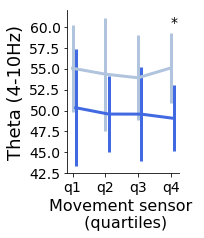

In [2393]:
fig,ax = plt.subplots(ncols=1, nrows=1, figsize=(2,3), facecolor='w')

plt.errorbar(range(4),np.mean(gama_quart_mov[:,:,0], axis=0), 
             yerr=np.std(gama_quart_mov[:,:,0], axis=0), color=plo['arena_early'], linewidth=3)
plt.errorbar(np.arange(4)+0.1,np.mean(gama_quart_mov[:,:,1], axis=0),
             yerr=np.std(gama_quart_mov[:,:,1], axis=0), color=plo['arena_late'], linewidth=3)

for qqq in range(4):
    s,p = stats.ttest_ind(gama_quart_mov[:,qqq,0],gama_quart_mov[:,qqq,1])
    if p<0.06: 
        plt.text(qqq+0.1, 60.5,'*', ha='center', va='center',  color='k', fontsize=14)


if band_of_int == 'theta':
    plt.ylabel('Theta (' + str(low_amp_freq)+'-'+str(high_amp_freq) + 'Hz)',fontsize=18)
if band_of_int == 'gamma':
    plt.ylabel('Gamma (' + str(low_amp_freq)+'-'+str(high_amp_freq) + 'Hz)',fontsize=18)

plt.xlabel('Movement sensor \n (quartiles)',fontsize=labels_fontsize)
plt.xticks( range(4), ['q1','q2','q3','q4'], fontsize=ticks_fontsize )
plt.yticks( fontsize=ticks_fontsize )

sns.despine()

In [1544]:
print('='*35)
print( 'movement quartile amplitude at early vs late' )
print(band_of_int )
print('='*35)
for qqq in range(4):
    print( 'Quartile_'+str(qqq+1), ' ',  stats.ttest_ind(gama_quart_mov[:,qqq,0],gama_quart_mov[:,qqq,1]) )

movement quartile amplitude at early vs late
gamma
Quartile_1   Ttest_indResult(statistic=0.05975299218014869, pvalue=0.9535296367146522)
Quartile_2   Ttest_indResult(statistic=-0.20276371333513496, pvalue=0.8433857710829042)
Quartile_3   Ttest_indResult(statistic=-0.38354674134493405, pvalue=0.7093425122154136)
Quartile_4   Ttest_indResult(statistic=-0.6032795196035359, pvalue=0.5597563494733473)


In [1545]:
print('='*35)
print( 'movement quartile amplitude at early vs late (Mean,std,sem)' )
print(band_of_int )
print('='*35)
print( '   Early: mean,std,sem', ' ', np.mean(gama_quart_mov[:,:,0]), np.std(gama_quart_mov[:,:,0]), stats.sem(np.concatenate(gama_quart_mov[:,:,0])) )
print( '   Late: mean,std,sem', ' ', np.mean(gama_quart_mov[:,:,1]), np.std(gama_quart_mov[:,:,1]), stats.sem(np.concatenate(gama_quart_mov[:,:,1])) )
print('\n')

for qqq in range(4):
    print( 'Quartile_'+str(qqq+1), ' ',  stats.ttest_ind(gama_quart_mov[:,qqq,0],gama_quart_mov[:,qqq,1]) )
    print( '   Early: mean,std,sem', ' ', np.mean(gama_quart_mov[:,qqq,0]), np.std(gama_quart_mov[:,qqq,0]), stats.sem(gama_quart_mov[:,qqq,0]) )
    print( '   Late: mean,std,sem', ' ', np.mean(gama_quart_mov[:,qqq,1]), np.std(gama_quart_mov[:,qqq,1]), stats.sem(gama_quart_mov[:,qqq,1]) )
    print('\n')

movement quartile amplitude at early vs late (Mean,std,sem)
gamma
   Early: mean,std,sem   43.56009028156169 15.672694963086911 3.2679828069233348
   Late: mean,std,sem   46.04220045550576 13.43286624358657 2.8009462338885127


Quartile_1   Ttest_indResult(statistic=0.05975299218014869, pvalue=0.9535296367146522)
   Early: mean,std,sem   44.52977044246564 18.398435469964745 8.228030478096892
   Late: mean,std,sem   43.95285431020837 11.295764753911884 5.051619569518632


Quartile_2   Ttest_indResult(statistic=-0.20276371333513496, pvalue=0.8433857710829042)
   Early: mean,std,sem   44.27000556638134 16.734741185522974 7.484003775338958
   Late: mean,std,sem   46.226636193534915 13.621390469934108 6.0916710077680944


Quartile_3   Ttest_indResult(statistic=-0.38354674134493405, pvalue=0.7093425122154136)
   Early: mean,std,sem   42.80859069787078 13.317312504702853 5.955683207624714
   Late: mean,std,sem   46.266631333937845 15.135604457209656 6.768848089373919


Quartile_4   Ttest_indR

In [1428]:
print('='*35)
if band_of_int == 'theta':
    print('Theta (' + str(low_amp_freq)+'-'+str(high_amp_freq) + 'Hz)')
if band_of_int == 'gamma':
    print('Gamma (' + str(low_amp_freq)+'-'+str(high_amp_freq) + 'Hz)')
print('='*35)

for cond in range(2):

    print( '\n', ['Early','Late'][cond] )
    quart = np.ravel(np.tile(np.arange(4),6).reshape(6,4))
    sub   = np.ravel(np.repeat(np.arange(6),4).reshape(6,4))
    gm    = np.ravel(gama_quart_mov[:,:,cond])

    anovarm_data = np.array([sub,quart,gm]).T
    anovarm_data = pd.DataFrame(anovarm_data, columns=['sub','quart','gamapower'])
    aovrm = AnovaRM( anovarm_data, 'gamapower', 'sub', within=['quart'])
    res = aovrm.fit()
    
    print(res)
    print( stats.friedmanchisquare(*gama_quart_mov[:,:,cond].T) )
    print('\n\n')

Gamma (40-80Hz)

 Early
               Anova
      Num DF  Den DF F Value Pr > F
-----------------------------------
quart 3.0000 15.0000  0.5050 0.6847

FriedmanchisquareResult(statistic=0.6000000000000085, pvalue=0.8964323733419095)




 Late
               Anova
      Num DF  Den DF F Value Pr > F
-----------------------------------
quart 3.0000 15.0000  3.1592 0.0557

FriedmanchisquareResult(statistic=8.600000000000009, pvalue=0.0351101156759808)





# Gamma power

In [189]:
session_type = 'Arena'
session = 1

f_range = (40, 65)

power_amp = []
for rat in range(1,7):
    
    data = loadmat('data/Rat_'+str(rat)+'_Type_'+session_type+'_Session_'+str(session)+'.mat')

    for ii in range(data['LFP_data'].shape[1]):

        lfp = data['LFP_data'][:,ii]
        mov = data['mov_data'][0][ii]

        amp = amp_by_time(lfp, fs, f_range)
        power_amp.append(  [rat, ii, mov, np.nanmean(amp)]  )
        
power_amp = np.array(power_amp)
power_amp = pd.DataFrame(power_amp, columns=['rat','chunk','mov','amp'])

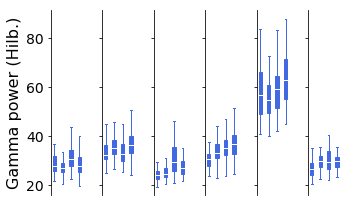

In [192]:
gamma_hilb_early = []
gamma_hilb_late = []

gamma_hilb_P1 = []
gamma_hilb_P2 = []
gamma_hilb_P3 = []
gamma_hilb_P4 = []


fig,ax = plt.subplots(ncols=6, nrows=1, figsize=(5,3), facecolor='w', sharey=True )

for rat in range(1,7):
    
    tmp = power_amp.query(' rat==' + str(rat))
    split = tmp['chunk'].values.max()/4
    
    plt.sca(ax[rat-1])
    
#     early_amp = tmp.query('chunk<'+str(split) ).amp.values
#     late_amp = tmp.query(  'chunk>'+str(split*2)+  '& chunk<'+str(split*3) ).amp.values
    P1_amp = tmp.query('chunk<'+str(split) ).amp.values
    P2_amp = tmp.query(  'chunk>'+str(split)+' & chunk<'+str(split*2) ).amp.values
    P3_amp = tmp.query(  'chunk>'+str(split*2)+' & chunk<'+str(split*3) ).amp.values
    P4_amp = tmp.query(  'chunk>'+str(split*3) ).amp.values

    
#     pval = stats.ttest_ind(early_amp,late_amp)[1]
#     sig_star = ''
#     if pval<=0.05: sig_star = '*' 
#     if pval<=0.01: sig_star = '**' 
#     if pval<=0.001: sig_star = '***' 
#     plt.text(0.6, 0.9,sig_star, ha='center', va='center', transform=ax[rat-1].transAxes, color='k', fontsize=14)
    
    
#     bxp = plt.boxplot(early_amp, positions=[0], sym='',widths=.4, patch_artist=True)
#     for item in ['boxes','whiskers','fliers','caps']: plt.setp(bxp[item],color=plo['arena_early'])
#     plt.setp(bxp['medians'],color='white')
    
#     bxp = plt.boxplot(late_amp, positions=[1], sym='',widths=.4, patch_artist=True)
#     for item in ['boxes','whiskers','fliers','caps']: plt.setp(bxp[item],color=plo['arena_late'])
#     plt.setp(bxp['medians'],color='white')


    bxp = plt.boxplot(P1_amp, positions=[0], sym='',widths=.4, patch_artist=True)
    for item in ['boxes','whiskers','fliers','caps']: plt.setp(bxp[item],color=plo['arena_late'])
    plt.setp(bxp['medians'],color='white')

    bxp = plt.boxplot(P2_amp, positions=[1], sym='',widths=.4, patch_artist=True)
    for item in ['boxes','whiskers','fliers','caps']: plt.setp(bxp[item],color=plo['arena_late'])
    plt.setp(bxp['medians'],color='white')

    bxp = plt.boxplot(P3_amp, positions=[2], sym='',widths=.4, patch_artist=True)
    for item in ['boxes','whiskers','fliers','caps']: plt.setp(bxp[item],color=plo['arena_late'])
    plt.setp(bxp['medians'],color='white')

    bxp = plt.boxplot(P4_amp, positions=[3], sym='',widths=.4, patch_artist=True)
    for item in ['boxes','whiskers','fliers','caps']: plt.setp(bxp[item],color=plo['arena_late'])
    plt.setp(bxp['medians'],color='white')


    if rat==1: plt.ylabel('Gamma power (Hilb.)', fontsize=labels_fontsize)
    plt.xticks([])
    plt.yticks(fontsize=ticks_fontsize)
    plt.xlim(-.4,3.6)
    plt.locator_params(axis='y', nbins=4)
    
#     gamma_hilb_early.append( np.median(early_amp) )
#     gamma_hilb_late.append( np.median(late_amp) )

    gamma_hilb_P1.append( np.median(P1_amp) )
    gamma_hilb_P2.append( np.median(P2_amp) )
    gamma_hilb_P3.append( np.median(P3_amp) )
    gamma_hilb_P4.append( np.median(P4_amp) )

sns.despine(bottom=True)
plt.tight_layout()

In [193]:
# gamma_hilb_early = np.array(gamma_hilb_early)
# gamma_hilb_late = np.array(gamma_hilb_late)

gamma_hilb_P1 = np.array(gamma_hilb_P1)
gamma_hilb_P2 = np.array(gamma_hilb_P2)
gamma_hilb_P3 = np.array(gamma_hilb_P3)
gamma_hilb_P4 = np.array(gamma_hilb_P4)

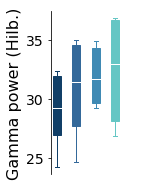

In [372]:
fig,ax = plt.subplots( figsize=(1.5,3), facecolor='w')

# plt.plot( np.arange(4)+0.5, [gamma_hilb_P1,gamma_hilb_P2,gamma_hilb_P3,gamma_hilb_P4], 'o', color='grey')

# bxp = plt.boxplot(gamma_hilb_early, positions=[0], sym='',widths=.2, patch_artist=True)
# for item in ['boxes','whiskers','fliers','caps']: plt.setp(bxp[item],color=plo['arena_early'])
# plt.setp(bxp['medians'],color='white')

# bxp = plt.boxplot(gamma_hilb_late, positions=[1], sym='',widths=.2, patch_artist=True)
# for item in ['boxes','whiskers','fliers','caps']: plt.setp(bxp[item],color=plo['arena_late'])
# plt.setp(bxp['medians'],color='white')

bxp = plt.boxplot(gamma_hilb_P1, positions=[0], sym='',widths=.4, patch_artist=True)
for item in ['boxes','whiskers','fliers','caps']: plt.setp(bxp[item],color=plo['P1'])
plt.setp(bxp['medians'],color='white')

bxp = plt.boxplot(gamma_hilb_P2, positions=[1], sym='',widths=.4, patch_artist=True)
for item in ['boxes','whiskers','fliers','caps']: plt.setp(bxp[item],color=plo['P2'])
plt.setp(bxp['medians'],color='white')

bxp = plt.boxplot(gamma_hilb_P3, positions=[2], sym='',widths=.4, patch_artist=True)
for item in ['boxes','whiskers','fliers','caps']: plt.setp(bxp[item],color=plo['P3'])
plt.setp(bxp['medians'],color='white')

bxp = plt.boxplot(gamma_hilb_P4, positions=[3], sym='',widths=.4, patch_artist=True)
for item in ['boxes','whiskers','fliers','caps']: plt.setp(bxp[item],color=plo['P4'])
plt.setp(bxp['medians'],color='white')


# plt.text(0.6, 0.98,"*", fontsize=18, ha='center', va='center', transform=ax.transAxes, color='k')

# plt.ylim(0.103,0.117)
plt.xticks([])
plt.xlim(-.3,4)
plt.ylabel('Gamma power (Hilb.)', fontsize=labels_fontsize)
plt.yticks(fontsize=ticks_fontsize)
plt.locator_params(axis='y', nbins=2)

sns.despine(bottom=True)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/stats/morestats.py:2778: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/stats/morestats.py:2778: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


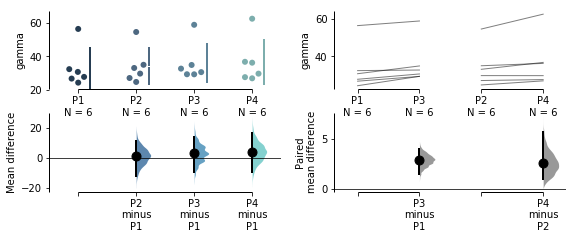

In [390]:

### Format data for dabest
gamma_hilb_means = np.array([gamma_hilb_P1,gamma_hilb_P2,gamma_hilb_P3,gamma_hilb_P4])
cond = np.array((['P1','P2','P3','P4']*6)).reshape(6,4).T
subs = np.tile(np.arange(6),4).reshape(4,6)
gamma_hilb_means_formated = np.array([np.ravel(subs),np.ravel(cond),np.ravel(gamma_hilb_means)]).T
gamma_hilb_means_pd = pd.DataFrame( data=gamma_hilb_means_formated, columns=['sub','exploration','gamma'] )
gamma_hilb_means_pd['gamma'] = gamma_hilb_means_pd['gamma'].astype(float)



### Compute dabest
gamma_hilb_means_dabest = dabest.load(data=gamma_hilb_means_pd, x='exploration', y='gamma',
                                       idx=("P1", "P2", "P3", "P4"))

gamma_hilb_means_dabest_paired = dabest.load(data=gamma_hilb_means_pd, x='exploration', y='gamma',
                                      idx=(("P1", "P3"),
                                           ("P2", "P4")), paired=True, id_col="sub")


#### plot dabest
fig,ax = plt.subplots(ncols=2,nrows=1, figsize=(8,2), facecolor='w')
gamma_hilb_means_dabest.mean_diff.plot( ax=ax[0], custom_palette=P_color_palette );
gamma_hilb_means_dabest_paired.mean_diff.plot( ax=ax[1] );
plt.tight_layout()

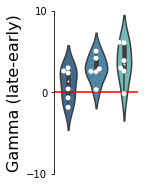

In [351]:
fig,ax = plt.subplots( figsize=(1.5,3), facecolor='w')

tmp_data = [gamma_hilb_P2-gamma_hilb_P1,
            gamma_hilb_P3-gamma_hilb_P1,
            gamma_hilb_P4-gamma_hilb_P1]

tmp_data = np.array(tmp_data).T

sns.violinplot(data=tmp_data,  palette=[plo['P2'],plo['P3'],plo['P4']] )
sns.swarmplot(data=tmp_data, color='w' )


# plt.text(0.5, 0.98,"**", fontsize=18, ha='center', va='center', transform=ax.transAxes, color='k')

# plt.ylim(0.103,0.117)
plt.xticks([])
plt.ylim(-10,10)
plt.hlines(0,-1,4, 'r')
plt.ylabel('Gamma (late-early)', fontsize=labels_fontsize)
plt.yticks(fontsize=ticks_fontsize-4)
plt.locator_params(axis='y', nbins=2)

sns.despine(bottom=True)

# plt.savefig("Figures/gamma_power_population.png",dpi=400, bbox_inches='tight', pad_inches=0.1)

In [388]:
n_compar = 3
for ii in range(n_compar):
    compare_test = stats.ttest_ind( np.zeros(tmp_data.shape[0]), tmp_data[ii])
    if compare_test[1] <  0.06/n_compar:
        print(ii, compare_test)
print( '\n', stats.friedmanchisquare(*tmp_data.T) )


gamma_pd = []
for sub in range(tmp_data.shape[0]):
    for cond in range(tmp_data.shape[1]):
        gamma_pd.append( [sub, cond, tmp_data[sub,cond]] )
gamma_pd = pd.DataFrame( data=np.array(gamma_pd), columns=['sub','cond','gamma'] )
aovrm = AnovaRM(gamma_pd, 'gamma', 'sub', within=['cond'])
res = aovrm.fit()
print(res)

# stats.ttest_rel(gamma_hilb_P1,gamma_hilb_P3)

1 Ttest_indResult(statistic=-3.3251107190958207, pvalue=0.012675803267657068)
2 Ttest_indResult(statistic=-3.071184486793737, pvalue=0.01803744676561999)

 FriedmanchisquareResult(statistic=3.0, pvalue=0.22313016014842982)
              Anova
     Num DF  Den DF F Value Pr > F
----------------------------------
cond 2.0000 10.0000  2.6424 0.1199



In [931]:
print( 'Hilbert gamma amplitude: population level, two-sided t-test' )
print( stats.ttest_rel(gamma_hilb_early,gamma_hilb_late) )
print( 'CohenEffectSize', CohenEffectSize(gamma_hilb_early,gamma_hilb_late))
print( 'Early mean/std', np.mean(gamma_hilb_early), np.std(gamma_hilb_early)  )
print( 'Late mean/std', np.mean(gamma_hilb_late), np.std(gamma_hilb_late)  )

Hilbert gamma amplitude: population level, two-sided t-test
Ttest_relResult(statistic=-4.389647282509388, pvalue=0.007090219656586514)
CohenEffectSize -0.2724887210774144
Early mean/std 33.05224907490191 10.828178297658798
Late mean/std 35.95865957353261 10.50165880854407


# Gamma bursting 

#### Exploring a novel arena triggers longer gamma (40,60) bursts at early exploration compared to later exploration

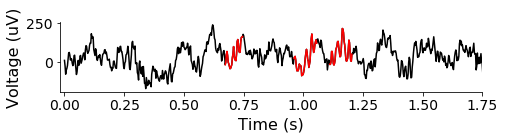

In [1000]:
# rat = 1
# data = loadmat('data/Rat_'+str(rat)+'_Type_'+session_type+'_Session_'+str(session)+'.mat')

ii = 8
sig = data['LFP_data'][:,ii]
times = np.linspace(0, sig.size/fs, sig.size)

# Burst settings
amp_dual_thresh = (1., 1.5)
f_range = (40, 60)
# Detect bursts of high amplitude oscillations in the extracted signal
bursting = detect_bursts_dual_threshold(sig, fs, amp_dual_thresh, f_range )
# Plot original signal and burst activity
fig,ax = plt.subplots( figsize=(7,2), facecolor='w')
plot_bursts(times, sig, bursting, ax=ax)
plt.xlim(-.02,1.75)
sns.despine()

plt.xticks(fontsize=ticks_fontsize)
plt.yticks(fontsize=ticks_fontsize)


plt.savefig("Figures/gamma_bursting_example.png",dpi=400, bbox_inches='tight', pad_inches=0.1)

In [391]:
amp_dual_thresh = (1., 1.5)
f_range = (40, 60)


session = 1
session_type = 'Arena'

gamma_burst = []
for rat in range(1,7):

    data = loadmat('data/Rat_'+str(rat)+'_Type_'+session_type+'_Session_'+str(session)+'.mat')

    for ii in range(data['LFP_data'].shape[1]):

        sig = data['LFP_data'][:,ii]
        mov = data['mov_data'][0][ii]

        bursting = detect_bursts_dual_threshold(sig, fs, amp_dual_thresh, f_range )

        tmp = np.diff(bursting.astype(int))

        if np.where(tmp==-1)[0].size == np.where(tmp==1)[0].size:
            for dur in np.where(tmp==-1)[0] - np.where(tmp==1)[0]:
                gamma_burst.append(  [rat,ii,mov,dur]  )
                
gamma_burst = np.array(gamma_burst)

In [392]:
anovarm_data = pd.DataFrame(gamma_burst, columns=['sub', 'chunk', 'mov','duration'])

burst_duration = []
splits = []
for rat in range(1,7):
    
    tmp = anovarm_data.query(' sub==' + str(rat))
    split = tmp['chunk'].values.max()/4

#     burst_duration.append( [  np.mean(tmp.query('chunk<'+str(split) ).duration.values) /fs,
#                              np.mean(tmp.query(  'chunk>'+str(split*2) ).duration.values) /fs ] )

    burst_duration.append( [  np.mean(tmp.query( 'chunk<'+str(split)                          ).duration.values) /fs,
                              np.mean(tmp.query( 'chunk>'+str(split)+' & chunk<'+str(split*2) ).duration.values) /fs,
                              np.mean(tmp.query( 'chunk>'+str(split*2)+' & chunk<'+str(split*3) ).duration.values) /fs,
                              np.mean(tmp.query( 'chunk>'+str(split*3)+' & chunk<'+str(split*4) ).duration.values) /fs                           
                           ] )

    
    splits.append(split)
burst_duration = np.array(burst_duration)


Rat: 1
Early, 0.7383854497480773 0.023409595851484232 0.0005480091779298278
Late, 0.011523051631029164 0.16705722743061374 0.027908117236803805
Rat: 2
Early, 0.06875341660107258 0.11623966832908221 0.013511660493255037
Late, 0.6654109818594636 0.028665538177868707 0.0008217130790268484
Rat: 3
Early, 0.16719757663087728 -0.09366793274776393 0.008773681625239626
Late, 0.5992409946748334 0.029911713664132342 0.0008947106143250415
Rat: 4
Early, 0.3779209469011455 -0.05289337582304702 0.002797709205958095
Late, 0.25372603918596043 -0.06329564415698924 0.004006338569248206
Rat: 5
Early, 0.2779301954954435 -0.06601886234784474 0.004358490185703672
Late, 0.7559008270517118 -0.017555926765220563 0.00030821056458578774
Rat: 6
Early, 0.13164295493319803 0.10104173506700583 0.010209432225350994
Late, 0.23706589991385651 -0.07914059741694177 0.0062632341595104495


Text(0.5, -0.04, 'Movement sensor')

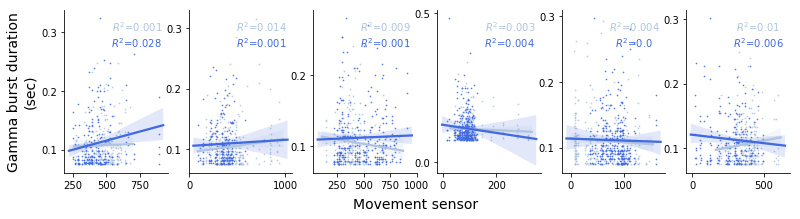

In [360]:
fig,ax = plt.subplots(ncols=6, nrows=1, figsize=(13,3), facecolor='w' )
for rat in range(1,7):
    tmp = anovarm_data.query(' sub==' + str(rat))
    split = tmp['chunk'].values.max()/4
    plt.sca(ax[rat-1])
    
    early_duration = tmp.query('chunk<'+str(split) ).duration.values/fs
    early_mov = tmp.query('chunk<'+str(split) ).mov.values
    
    late_duration = tmp.query(  'chunk>'+str(split*2)+  '& chunk<'+str(split*3) ).duration.values/fs
    late_mov = tmp.query(  'chunk>'+str(split*2)+  '& chunk<'+str(split*3)).mov.values
    
    
    print('Rat:',rat)
    re,pe = stats.pearsonr(early_mov, early_duration)
    print('Early,', pe,re,re**2)
    rl,pl = stats.pearsonr(late_mov, late_duration)
    print('Late,', pl,rl,rl**2)

    
    
    
    sns.regplot( early_mov, early_duration, scatter=True, marker='.',
                scatter_kws={'s':2}, color=plo['arena_early'] )
    sns.regplot( late_mov, late_duration, scatter=True, marker='.', 
                scatter_kws={'s':2}, color=plo['arena_late'] )
    sns.despine()
    
    rr_string_1 = r'$R^2$=' + str(np.around(re**2,3))
    rr_string_2 = r'$R^2$=' + str(np.around(rl**2,3))    
    plt.text(0.7, 0.9,rr_string_1, ha='center', va='center', transform=ax[rat-1].transAxes, color=plo['arena_early'])
    plt.text(0.7, 0.8,rr_string_2, ha='center', va='center', transform=ax[rat-1].transAxes, color=plo['arena_late'])

    plt.locator_params(axis='y', nbins=2)
    plt.locator_params(axis='x', nbins=2)
    
    if rat==1: plt.ylabel('Gamma burst duration\n(sec)', fontsize=14)
        

    
fig.text(0.5, -0.04, 'Movement sensor', ha='center', fontsize=14)


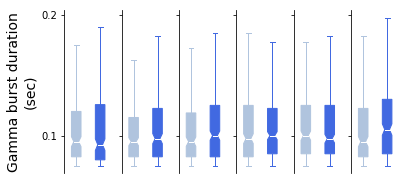

In [361]:
fig,ax = plt.subplots(ncols=6, nrows=1, figsize=(6,3), sharey=True )
for rat in range(1,7):
    tmp = anovarm_data.query(' sub==' + str(rat))
    split = tmp['chunk'].values.max()/4
    plt.sca(ax[rat-1])
    
    early_duration = tmp.query('chunk<'+str(split)  ).duration.values/fs
    early_mov = tmp.query('chunk<'+str(split) ).mov.values
    
    late_duration = tmp.query(  'chunk>'+str(split*2)+  '& chunk<'+str(split*3) ).duration.values/fs
    late_mov = tmp.query(  'chunk>'+str(split*2)+  '& chunk<'+str(split*3) ).mov.values
    
    
    
    
    
    bxp = plt.boxplot(early_duration, positions=[0], sym='',widths=.4, patch_artist=True, notch=True )
    for item in ['boxes','whiskers','fliers','caps']: plt.setp(bxp[item],color=plo['arena_early'])
    plt.setp(bxp['medians'],color='white')


    bxp = plt.boxplot(late_duration, positions=[1], sym='',widths=.4, patch_artist=True, notch=True)        
    for item in ['boxes','whiskers','fliers','caps']: plt.setp(bxp[item],color=plo['arena_late'])
    plt.setp(bxp['medians'],color='white')

    if stats.ttest_ind(early_duration,late_duration)[1]<=0.055:
        plt.text(0.5, 0.9,"*", ha='center', va='center', transform=ax[rat-1].transAxes, color='k')
    
    plt.locator_params(axis='y', nbins=2)
    plt.locator_params(axis='x', nbins=2)
    plt.xlim(-.5,1.5)
    plt.xticks([])
    
    if rat==1: plt.ylabel('Gamma burst duration\n(sec)', fontsize=14)
        

sns.despine(bottom=True)



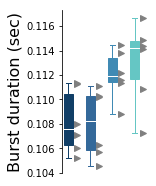

In [414]:
fig,ax = plt.subplots( figsize=(1.5,3), facecolor='w')

plt.plot( np.arange(4)+0.4, burst_duration.T, '>', color='grey' );
# plt.errorbar([0,1],[np.mean(burst_duration[:,0]),np.mean(burst_duration[:,1])],
#              yerr=[stats.sem(burst_duration[:,0]),stats.sem(burst_duration[:,1])],
#             linewidth=0, color='k', elinewidth=4 )

# plt.boxplot( [ burst_duration[:,0],burst_duration[:,1] ], positions=[0,1], sym='' );

bxp = plt.boxplot(burst_duration[:,0], positions=[0], sym='',widths=.4, patch_artist=True)
for item in ['boxes','whiskers','fliers','caps']: plt.setp(bxp[item],color=plo['P1'])
plt.setp(bxp['medians'],color='white')

bxp = plt.boxplot(burst_duration[:,1], positions=[1], sym='',widths=.4, patch_artist=True)
for item in ['boxes','whiskers','fliers','caps']: plt.setp(bxp[item],color=plo['P2'])
plt.setp(bxp['medians'],color='white')


bxp = plt.boxplot(burst_duration[:,2], positions=[2], sym='',widths=.4, patch_artist=True)
for item in ['boxes','whiskers','fliers','caps']: plt.setp(bxp[item],color=plo['P3'])
plt.setp(bxp['medians'],color='white')


bxp = plt.boxplot(burst_duration[:,3], positions=[3], sym='',widths=.4, patch_artist=True)
for item in ['boxes','whiskers','fliers','caps']: plt.setp(bxp[item],color=plo['P4'])
plt.setp(bxp['medians'],color='white')

# plt.text(0.5, 0.98,"**", fontsize=18, ha='center', va='center', transform=ax.transAxes, color='k')


# plt.ylim(0.103,0.117)
plt.xticks([])
plt.xlim(-.3,3.5)
plt.ylabel('Burst duration (sec)', fontsize=labels_fontsize)
plt.yticks(fontsize=10)

sns.despine(bottom=True)


# plt.savefig("Figures/gamma_burst_population.png",dpi=400, bbox_inches='tight', pad_inches=0.1)

In [420]:
print('='*35)
print('Gamma burst duration')
print( stats.ttest_rel(burst_duration[:,0],burst_duration[:,2]) )
print( 'CohenEffectSize', CohenEffectSize(burst_duration[:,0],burst_duration[:,2]))
print('\n')
print('Gamma burst duration mean,std,sem')
print('P1', np.mean(burst_duration[:,0]), np.std(burst_duration[:,0]), stats.sem(burst_duration[:,0]) )
print('P2', np.mean(burst_duration[:,1]), np.std(burst_duration[:,1]), stats.sem(burst_duration[:,1]) )
print('P3', np.mean(burst_duration[:,2]), np.std(burst_duration[:,2]), stats.sem(burst_duration[:,2]) )
print('P4', np.mean(burst_duration[:,3]), np.std(burst_duration[:,3]), stats.sem(burst_duration[:,3]) )

Gamma burst duration
Ttest_relResult(statistic=-4.086884566468175, pvalue=0.009475691002111318)
CohenEffectSize -1.8238535143617887


Gamma burst duration mean,std,sem
P1 0.10815859528464804 0.0023911501674789668 0.0010693548637785955
P2 0.10803516842019749 0.0025824248767804332 0.0011548955142535134
P3 0.11203327233023445 0.00181904827615903 0.0008135031199690804
P4 0.11302562602666179 0.0031105572394245634 0.0013910834870514827


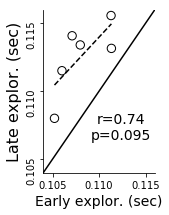

In [988]:



fig,ax = plt.subplots( figsize=(2,3), facecolor='w')

x,y = burst_duration[:,0],burst_duration[:,1]
plt.scatter(x,y, s=70, facecolors='none', edgecolors='k')

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
xp = np.linspace(x.min(), x.max(), 10)
plt.plot(xp, p(xp), 'k--')

plt.plot( [.104,.116], [.104,.116] , 'k' )

r,p = stats.pearsonr(burst_duration[:,0],burst_duration[:,1] )
r = str(np.around(r,2))
p = str(np.around(p,3))
sig_string = 'r='+r+'\n'+'p='+p
plt.text(0.7, 0.28,sig_string, fontsize=ticks_fontsize, ha='center', va='center', transform=ax.transAxes, color='k')


plt.xlim(.104,.116)
plt.ylim(.104,.116)
plt.xlabel('Early explor. (sec)', fontsize=labels_fontsize-2)
plt.ylabel('Late explor. (sec)', fontsize=labels_fontsize)
plt.locator_params(axis='x', nbins=2)
plt.locator_params(axis='y', nbins=2)
plt.yticks(rotation=90)


sns.despine()


plt.savefig("Figures/gamma_burst_duration_correlation.png",dpi=400, bbox_inches='tight', pad_inches=0.1)

In [1501]:
print('='*35)
print('Gamma burst early-late correlation')
print( 'pearsonr:', stats.pearsonr(burst_duration[:,0],burst_duration[:,1] ) )

Gamma burst early-late correlation
pearsonr: (0.7362871488984302, 0.09514681680847596)


# Lagged coherence

In [990]:
# Settings for lagged coherence, as frequency range (start, stop, step)
f_range = (4, 80, .5)
fs = 400.


LC_all_early,LC_all_late  = [],[]
for rat in range(1,7):
    
    data = loadmat('data/Rat_'+str(rat)+'_Type_'+session_type+'_Session_'+str(session)+'.mat')
    
    rat_mov = data['mov_data'][0]
    split = int(rat_mov.size/4)

    lfp_early = np.ravel(data['LFP_data'][:,:split].T)
    lfp_late  = np.ravel(data['LFP_data'][:,split*2:split*3].T)

    LC_early, freqs = compute_lagged_coherence(  lfp_early, fs, f_range, return_spectrum=True)
    LC_late, freqs = compute_lagged_coherence(  lfp_late, fs, f_range, return_spectrum=True)
    
    LC_all_early.append(  LC_early )
    LC_all_late.append(  LC_late )
    
LC_all_early = np.array(LC_all_early)
LC_all_late = np.array(LC_all_late)

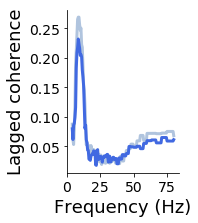

In [992]:
fig = plt.figure( figsize=(2,3), facecolor='w')

plt.plot(freqs, np.mean(LC_all_early,axis=0), color=plo['arena_early'], linewidth=3)
plt.plot(freqs, np.mean(LC_all_late,axis=0), color=plo['arena_late'], linewidth=3)

plt.ylabel("Lagged coherence", fontsize=18)
plt.xlabel("Frequency (Hz)", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

sns.despine()

plt.savefig("Figures/lagged_coherence.png",dpi=400, bbox_inches='tight', pad_inches=0.1)

In [1524]:
print('='*60)
print('Lagged coherence')
print( 'Peak early:', freqs[np.argmax(np.mean(LC_all_early,axis=0))] )
print( 'Peak late:' , freqs[np.argmax(np.mean(LC_all_late,axis=0))]  )
print('>>> Not significant')

Lagged coherence
Peak early: 9.0
Peak late: 8.5
>>> Not significant


In [1520]:
freqs[np.where(stats.ttest_ind(LC_all_early,LC_all_late)[1]<=0.05)[0]]

array([21.5, 22. ])

# Cycle feature analysis

In [205]:
f_theta = (4, 10)

In [206]:
session_type = 'Arena'
session = 1


# Apply a lowpass filter at 25Hz
fc = 25
filter_seconds = .5


osc_kwargs = {'amplitude_fraction_threshold': 0,
                              'amplitude_consistency_threshold': .6,
                              'period_consistency_threshold': .75,
                              'monotonicity_threshold': .8,
                              'N_cycles_min': 3}

f_lowpass = 30
N_seconds = .5
narrowband_kwargs = {'N_seconds': .5}


# df_early, df_late = [], []
df_P1 = []
df_P2 = []
df_P3 = []
df_P4 = []

for rat in range(1,7):

    data = loadmat('data/Rat_'+str(rat)+'_Type_'+session_type+'_Session_'+str(session)+'.mat')

    rat_mov = data['mov_data'][0]
    split = int(rat_mov.size/4)

#     lfp_early = np.ravel(data['LFP_data'][:,:split].T)
#     lfp_late  = np.ravel(data['LFP_data'][:,split*2:split*3].T)

    lfp_P1 = np.ravel(data['LFP_data'][:split].T)
    lfp_P2 = np.ravel(data['LFP_data'][split:split*2].T)
    lfp_P3 = np.ravel(data['LFP_data'][split*2:split*3].T)
    lfp_P4 = np.ravel(data['LFP_data'][split*3:].T)


    # Cycle-by-cycle analysis
#     tmp_df_early = compute_features(lfp_early, fs, f_theta, center_extrema='T',
#                                  burst_detection_kwargs=osc_kwargs)
#     tmp_df_early['rat'] = np.ones(tmp_df_early.shape[0])*rat
    

#     tmp_df_late = compute_features(lfp_late, fs, f_theta, center_extrema='T',
#                                  burst_detection_kwargs=osc_kwargs)
#     tmp_df_late['rat'] = np.ones(tmp_df_late.shape[0])*rat

    tmp_df_P1 = compute_features(lfp_P1, fs, f_theta, center_extrema='T',
                                 burst_detection_kwargs=osc_kwargs)
    tmp_df_P1['rat'] = np.ones(tmp_df_P1.shape[0])*rat

    tmp_df_P2 = compute_features(lfp_P2, fs, f_theta, center_extrema='T',
                                 burst_detection_kwargs=osc_kwargs)
    tmp_df_P2['rat'] = np.ones(tmp_df_P2.shape[0])*rat

    tmp_df_P3 = compute_features(lfp_P3, fs, f_theta, center_extrema='T',
                                 burst_detection_kwargs=osc_kwargs)
    tmp_df_P3['rat'] = np.ones(tmp_df_P3.shape[0])*rat

    tmp_df_P4 = compute_features(lfp_P4, fs, f_theta, center_extrema='T',
                                 burst_detection_kwargs=osc_kwargs)
    tmp_df_P4['rat'] = np.ones(tmp_df_P4.shape[0])*rat



#     df_early.append(tmp_df_early)
#     df_late.append(tmp_df_late)

    df_P1.append(tmp_df_P1)
    df_P2.append(tmp_df_P2)
    df_P3.append(tmp_df_P3)
    df_P4.append(tmp_df_P4)
    
    
# df_early = pd.concat(df_early)
# df_late = pd.concat(df_late)

df_P1 = pd.concat(df_P1)
df_P2 = pd.concat(df_P2)
df_P3 = pd.concat(df_P3)
df_P4 = pd.concat(df_P4)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


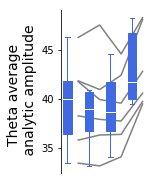

In [207]:
feature = 'band_amp'

fig,ax = plt.subplots( figsize=(1.5,3), facecolor='w')

# plt.plot( [0.2,0.8], [df_early.groupby('rat')[feature].mean(), df_late.groupby('rat')[feature].mean()], 'grey' )
plt.plot( np.arange(4)+0.5, [df_P1.groupby('rat')[feature].mean(), 
                             df_P2.groupby('rat')[feature].mean(),
                             df_P3.groupby('rat')[feature].mean(),
                             df_P4.groupby('rat')[feature].mean()] ,'grey' )

# bxp = plt.boxplot(df_early.groupby('rat')[feature].mean(), positions=[0], sym='',widths=.2, patch_artist=True)
# for item in ['boxes','whiskers','fliers','caps']: plt.setp(bxp[item],color=plo['arena_early'])
# plt.setp(bxp['medians'],color='white')

# bxp = plt.boxplot(df_late.groupby('rat')[feature].mean(), positions=[1], sym='',widths=.2, patch_artist=True)
# for item in ['boxes','whiskers','fliers','caps']: plt.setp(bxp[item],color=plo['arena_late'])
# plt.setp(bxp['medians'],color='white')

bxp = plt.boxplot(df_P1.groupby('rat')[feature].mean(), positions=[0], sym='',widths=.4, patch_artist=True)
for item in ['boxes','whiskers','fliers','caps']: plt.setp(bxp[item],color=plo['arena_late'])
plt.setp(bxp['medians'],color='white')

bxp = plt.boxplot(df_P2.groupby('rat')[feature].mean(), positions=[1], sym='',widths=.4, patch_artist=True)
for item in ['boxes','whiskers','fliers','caps']: plt.setp(bxp[item],color=plo['arena_late'])
plt.setp(bxp['medians'],color='white')

bxp = plt.boxplot(df_P3.groupby('rat')[feature].mean(), positions=[2], sym='',widths=.4, patch_artist=True)
for item in ['boxes','whiskers','fliers','caps']: plt.setp(bxp[item],color=plo['arena_late'])
plt.setp(bxp['medians'],color='white')

bxp = plt.boxplot(df_P4.groupby('rat')[feature].mean(), positions=[3], sym='',widths=.4, patch_artist=True)
for item in ['boxes','whiskers','fliers','caps']: plt.setp(bxp[item],color=plo['arena_late'])
plt.setp(bxp['medians'],color='white')


# plt.text(0.5, 0.98,"***", fontsize=18, ha='center', va='center', transform=ax.transAxes, color='k')

# plt.ylim(0.103,0.117)
plt.xticks([])
plt.xlim(-.3,3.6)
plt.ylabel('Theta average \n analytic amplitude', fontsize=14)
plt.yticks(fontsize=10)
plt.locator_params(axis='y', nbins=2)

sns.despine(bottom=True)





# print('='*35)
# print('Theta average analytic amplitude')
# print( stats.ttest_rel(df_early.groupby('rat')[feature].mean(), df_late.groupby('rat')[feature].mean()))
# print( 'CohenEffectSize', CohenEffectSize(df_early.groupby('rat')[feature].mean(), df_late.groupby('rat')[feature].mean()) )
# print('Theta average analytic amplitude Mean,std,sem \n')
# print( 'Early:', df_early.groupby('rat')[feature].mean().mean(), df_early.groupby('rat')[feature].mean().std(), df_early.groupby('rat')[feature].mean().sem())
# print( 'Late:', df_late.groupby('rat')[feature].mean().mean(), df_late.groupby('rat')[feature].mean().std(), df_late.groupby('rat')[feature].mean().sem())


# plt.savefig("Figures/theta_analytic.png",dpi=400, bbox_inches='tight', pad_inches=0.1)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/stats/morestats.py:2778: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/stats/morestats.py:2778: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


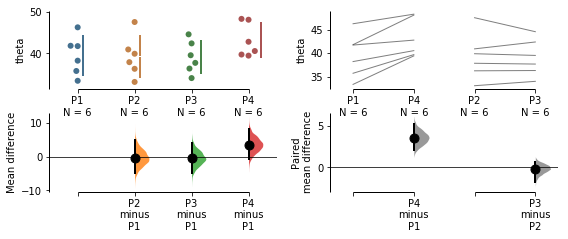

In [217]:
# theta_analytic_np = np.array([df_P1.groupby('rat')[feature].mean(), 
#                              df_P2.groupby('rat')[feature].mean(),
#                              df_P3.groupby('rat')[feature].mean(),
#                              df_P4.groupby('rat')[feature].mean()])



### Format data for dabest
cond = np.array((['P1','P2','P3','P4']*6)).reshape(6,4).T
subs = np.tile(np.arange(6),4).reshape(4,6)
theta_analytic_means_formated = np.array([np.ravel(subs),np.ravel(cond),np.ravel(theta_analytic_np)]).T
theta_analytic_means_pd = pd.DataFrame( data=theta_analytic_means_formated, columns=['sub','exploration','theta'] )
theta_analytic_means_pd['theta'] = theta_analytic_means_pd['theta'].astype(float)


### Compute dabest
theta_analytic_means_dabest = dabest.load(data=theta_analytic_means_pd, x='exploration', y='theta',
                                       idx=("P1", "P2", "P3", "P4"))

theta_analytic_means_dabest_paired = dabest.load(data=theta_analytic_means_pd, x='exploration', y='theta',
                                      idx=(("P1", "P4"),
                                           ("P2", "P3")), paired=True, id_col="sub")


#### plot dabest
fig,ax = plt.subplots(ncols=2,nrows=1, figsize=(8,2), facecolor='w')
theta_analytic_means_dabest.mean_diff.plot( ax=ax[0] );
theta_analytic_means_dabest_paired.mean_diff.plot( ax=ax[1] );
plt.tight_layout()

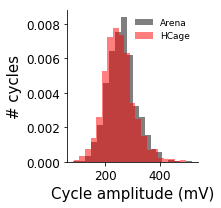

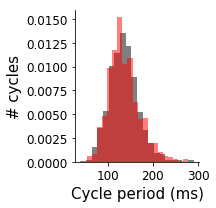

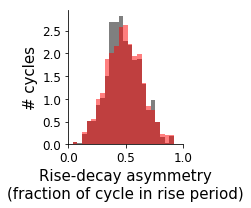

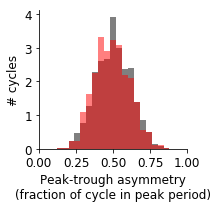

In [1286]:
fig = plt.figure(figsize=(3,3))
fig.set_facecolor('w')
plt.hist(df_arena_cycles['volt_amp'], bins=20, color='k', alpha=.5, label='Arena', density=True)
plt.hist(df_hcage_cycles['volt_amp'], bins=20, color='r', alpha=.5, label='HCage', density=True)
plt.legend(fontsize=9, frameon=False )
plt.yticks(size=12)
plt.xticks(size=12)
plt.xlabel('Cycle amplitude (mV)', size=15)
plt.ylabel('# cycles', size=15)
plt.tight_layout()
sns.despine()
plt.show()

fig = plt.figure(figsize=(3,3))
fig.set_facecolor('w')
plt.hist(df_arena_cycles['period'] / Fs * 1000, bins=20, color='k', alpha=.5,density=True)
plt.hist(df_hcage_cycles['period'] / Fs * 1000, bins=20, color='r', alpha=.5,density=True)
plt.xticks(size=12)
plt.yticks(size=12)
# plt.xlim((0,250))
plt.xlabel('Cycle period (ms)', size=15)
plt.ylabel('# cycles', size=15)
plt.tight_layout()
sns.despine()
plt.show()

fig = plt.figure(figsize=(3,3))
fig.set_facecolor('w')
plt.hist(df_arena_cycles['time_rdsym'], bins=np.arange(0, 1, .04), color='k', alpha=.5, density=True)
plt.hist(df_hcage_cycles['time_rdsym'], bins=np.arange(0, 1, .04), color='r', alpha=.5, density=True)
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlim((0,1))
plt.xlabel('Rise-decay asymmetry\n(fraction of cycle in rise period)', size=15)
plt.ylabel('# cycles', size=15)
plt.tight_layout()
sns.despine()
plt.show()

fig = plt.figure(figsize=(3,3))
fig.set_facecolor('w')
plt.hist(df_arena_cycles['time_ptsym'], bins=np.arange(0, 1, .04), color='k', alpha=.5, density=True)
plt.hist(df_hcage_cycles['time_ptsym'], bins=np.arange(0, 1, .04), color='r', alpha=.5, density=True)
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlim((0,1))
plt.xlabel('Peak-trough asymmetry\n(fraction of cycle in peak period)', size=12)
plt.ylabel('# cycles', size=12)
plt.tight_layout()
sns.despine()
plt.show()